<a href="https://colab.research.google.com/github/arutraj/.githubcl/blob/main/1_ARIMA_and_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to illustrate a way to approach a time-series forecasting problem. We will analyze the time-series data available and discuss Arima and Prophet to do the job. The data is uploaded to the folder "1-data".

We are given sales historic data for a bunch of shops and products of a Russian sofware company and the task is to forecast the total amount of products sold in every shop for the test set.

<a id = "quick_look"></a>
# Quick look at the data

Let's import all the necessary libraries and read the csv files:

In [1]:
from platform import python_version
print(python_version())

3.10.12


In [2]:
!pip install prophet

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams


# TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas import Timestamp
from datetime import datetime

#MODELLING
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
# settings
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [5]:
!unzip /content/"Dataset - uplevel-20241124T185710Z-001.zip"

Archive:  /content/Dataset - uplevel-20241124T185710Z-001.zip
  inflating: Dataset - uplevel/Copy of item_categories.csv  
  inflating: Dataset - uplevel/Copy of shops.csv  
  inflating: Dataset - uplevel/Copy of items.csv  
  inflating: Dataset - uplevel/Copy of test.csv  
  inflating: Dataset - uplevel/Copy of test(1).csv  
  inflating: Dataset - uplevel/Copy of train.csv  
  inflating: Dataset - uplevel/Copy of sales_train.csv  


Let's import the data:

In [12]:
df_cats=pd.read_csv('/content/Datasetuplevel/item_categories.csv')
df_items=pd.read_csv('/content/Datasetuplevel/items.csv')
df_sales=pd.read_csv('/content/Datasetuplevel/sales_train.csv')
df_shops=pd.read_csv('/content/Datasetuplevel/shops.csv')
df_test=pd.read_csv('/content/Datasetuplevel/test.csv')

Let's define the following function to get a quick summary of a dataframe

In [27]:
def overview(df):
    print('SHAPE:\n',df.shape)
    print('COLUMN NAMES:\n', df.columns.tolist())
    print('UNIQUE VALUES PER COLUMN:\n', df.nunique())
    print('COLUMNS WITH MISSING DATA:\n',df.isnull().sum())
    print('SAMPLE:\n',df.sample(10))
    print('INFO:\n',df.info())

<a id = "quick_look_sales_train"></a>
### sales_train

In [13]:
df_sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [28]:
overview(df_sales)

SHAPE:
 (2935846, 6)
COLUMN NAMES:
 ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
UNIQUE VALUES PER COLUMN:
 date               1034
date_block_num       34
shop_id              59
item_id           21806
item_price        19991
item_cnt_day        196
dtype: int64
COLUMNS WITH MISSING DATA:
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
SAMPLE:
                date  date_block_num  shop_id  item_id  item_price  \
1837614  17.07.2014              18       57    19900       169.0   
1835752  25.07.2014              18       13    19789       153.0   
1072309  24.11.2013              10        6     7852       249.0   
2185248  24.11.2014              22       43     6596       299.0   
1463331  29.03.2014              14       51    18958       312.0   
1212234  10.12.2013              11       51     1143       282.0   
223005   10.02.2013               1       28    

In [16]:
sorted(list(df_sales["item_cnt_day"].unique()))[:20]

[-22.0,
 -16.0,
 -9.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0]

In [17]:
sorted(list(df_sales["item_price"].unique()))[:20]

[-1.0,
 0.07,
 0.0875,
 0.09,
 0.1,
 0.2,
 0.5,
 0.908713692946,
 0.99,
 1.0,
 1.83,
 2.0,
 2.99,
 3.0,
 3.57,
 3.59,
 3.64,
 3.67,
 3.69,
 3.71]

In [18]:
df_sales[df_sales["item_price"]<0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0

In [ ]:
mean = df_sales[(df_sales["shop_id"] == 32) & (df_sales["item_id"] == 2973) & (df_sales["date_block_num"] == 4) & (df_sales["item_price"] > 0)]["item_price"].mean()
df_sales.loc[df_sales.item_price < 0, 'item_price'] = mean

In [29]:
# =============================================================================
# CLEANING DF_SALES
# =============================================================================

# Якутск Орджоникидзе, 56
df_sales.loc[df_sales.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_sales.loc[df_sales.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_sales.loc[df_sales.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

#create attribute revenue
df_sales['revenue']=df_sales['item_price']*df_sales['item_cnt_day']


AttributeError: 'DataFrame' object has no attribute 'shop_id'

Let's look for outliers

<Axes: xlabel='item_cnt_day'>

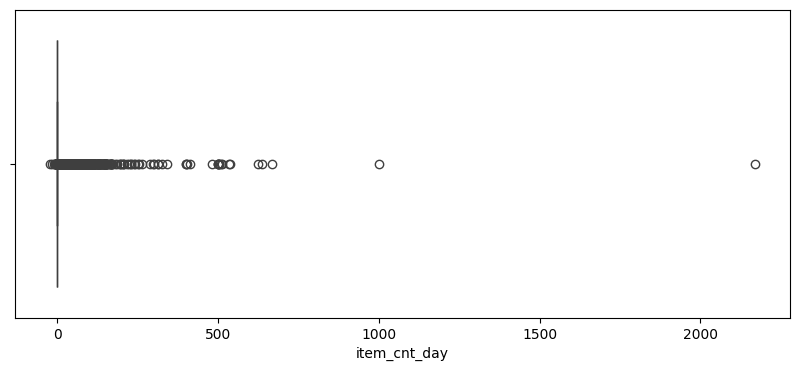

In [20]:
plt.figure(figsize = (10,4))
sns.boxplot(x = df_sales["item_cnt_day"])

In [21]:
df_sales[df_sales['item_cnt_day']>800]

date  date_block_num  shop_id  item_id  item_price  \
2326930  15.01.2015              24       12    20949    4.000000   
2909818  28.10.2015              33       12    11373    0.908714   

         item_cnt_day  
2326930        1000.0  
2909818        2169.0

<Axes: xlabel='item_price'>

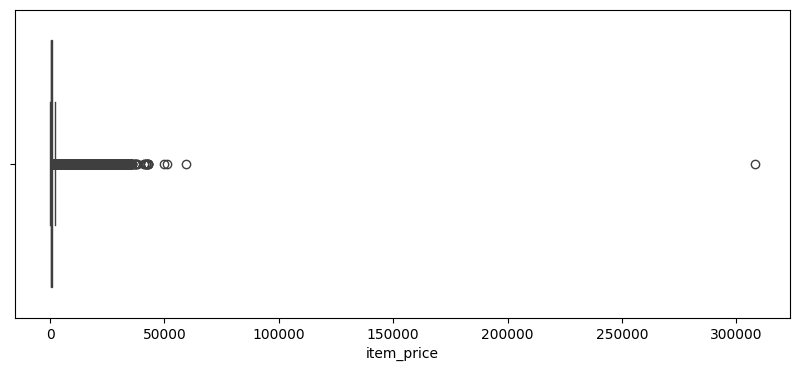

In [22]:
plt.figure(figsize = (10,4))
sns.boxplot(x = df_sales["item_price"])

In [23]:
df_sales[df_sales['item_price']>100000]

date  date_block_num  shop_id  item_id  item_price  \
1163158  13.12.2013              11       12     6066    307980.0   

         item_cnt_day  
1163158           1.0

In [24]:
df_sales = df_sales[(df_sales.item_price < 300000 )& (df_sales.item_cnt_day < 1000)]

<a id = "quick_look_items"></a>
### items

In [25]:
df_items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [30]:
overview(df_items)

SHAPE:
 (22170, 3)
COLUMN NAMES:
 ['item_name', 'item_id', 'item_category_id']
UNIQUE VALUES PER COLUMN:
 item_name           22170
item_id             22170
item_category_id       84
dtype: int64
COLUMNS WITH MISSING DATA:
 item_name           0
item_id             0
item_category_id    0
dtype: int64
SAMPLE:
                                                item_name  item_id  \
1401   Aliens: Colonial Marines. Season Pass [PC, Циф...     1401   
3783   HELLO KITTY И  ЕЕ ДРУЗЬЯ: СЧАСТЛИВОГО ХЭЛЛОУИН...     3783   
952                                2016: КОНЕЦ НОЧИ (BD)      952   
7372         V/A Ibiza House Summer 2012  2CD (digipack)     7372   
19714  ТОМ И ДЖЕРРИ. КЛАССИЧЕСКАЯ КОЛЛЕКЦИЯ. ТОМ 3 (2...    19714   
1076                               47 РОНИНОВ (3D BD+BD)     1076   
1586   Assassin's Creed: Синдикат. Чаринг-Кросс [PS4,...     1586   
21819                       ШАТУНОВ ЮРИЙ  Золотой альбом    21819   
12069          ИСТОРИЯ ИГРУШЕК. БОЛЬШОЙ ПОБЕГ/ВАЛЛИ (BD)    12069 

In [31]:
pd.options.display.max_rows =100

gb_item_cat=df_items.groupby('item_category_id').agg({'item_id':'count'})
gb_item_cat.sort_values('item_id',ascending=False,inplace=True)
gb_item_cat

item_id
item_category_id         
40                   5035
55                   2365
37                   1780
31                   1125
58                    790
30                    756
72                    666
19                    628
61                    598
23                    501
43                    471
57                    427
56                    397
67                    394
63                    366
76                    333
41                    332
69                    317
38                    310
62                    295
59                    294
64                    290
78                    278
75                    277
28                    240
70                    228
77                    220
45                    195
66                    178
20                    175
49                    167
65                    163
44                    161
47                    151
25                    140
21                    125
24                    123
54                     90
22                     79
2                      75
60                     52
29                     46
11                     41
6                      40
15                     37
73                     36
3                      34
5                      29
68                     27
7                      24
12                     20
16                     20
14                     18
33                     18
4                      15
83                     15
42                     12
46                     12
9                      12
8                       9
27                      8
82                      8
74                      8
34                      8
17                      7
81                      7
39                      7
18                      6
71                      6
13                      6
32                      6
80                      6
36                      6
48                      5
0                       4
35                      4
53                      3
52                      3
26                      3
1                       2
50                      2
10                      1
79                      1
51                      1

<a id = "quick_look_item_categories"></a>
### item_categories

In [32]:
df_cats.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [33]:
overview(df_cats)

SHAPE:
 (84, 2)
COLUMN NAMES:
 ['item_category_name', 'item_category_id']
UNIQUE VALUES PER COLUMN:
 item_category_name    84
item_category_id      84
dtype: int64
COLUMNS WITH MISSING DATA:
 item_category_name    0
item_category_id      0
dtype: int64
SAMPLE:
                           item_category_name  item_category_id
39                         Кино - Blu-Ray 4K                39
22                             Игры - PSVita                22
73              Программы - 1С:Предприятие 8                73
40                                Кино - DVD                40
71  Подарки - Сумки, Альбомы, Коврики д/мыши                71
30             Игры PC - Стандартные издания                30
76      Программы - Для дома и офиса (Цифра)                76
16                Игровые консоли - XBOX ONE                16
41                      Кино - Коллекционное                41
67                        Подарки - Развитие                67
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [34]:
df_cats

item_category_name  item_category_id
0                    PC - Гарнитуры/Наушники                 0
1                           Аксессуары - PS2                 1
2                           Аксессуары - PS3                 2
3                           Аксессуары - PS4                 3
4                           Аксессуары - PSP                 4
5                        Аксессуары - PSVita                 5
6                      Аксессуары - XBOX 360                 6
7                      Аксессуары - XBOX ONE                 7
8                             Билеты (Цифра)                 8
9                            Доставка товара                 9
10                     Игровые консоли - PS2                10
11                     Игровые консоли - PS3                11
12                     Игровые консоли - PS4                12
13                     Игровые консоли - PSP                13
14                  Игровые консоли - PSVita                14
15                Игровые консоли - XBOX 360                15
16                Игровые консоли - XBOX ONE                16
17                  Игровые консоли - Прочие                17
18                                Игры - PS2                18
19                                Игры - PS3                19
20                                Игры - PS4                20
21                                Игры - PSP                21
22                             Игры - PSVita                22
23                           Игры - XBOX 360                23
24                           Игры - XBOX ONE                24
25                 Игры - Аксессуары для игр                25
26                      Игры Android - Цифра                26
27                          Игры MAC - Цифра                27
28          Игры PC - Дополнительные издания                28
29           Игры PC - Коллекционные издания                29
30             Игры PC - Стандартные издания                30
31                           Игры PC - Цифра                31
32         Карты оплаты (Кино, Музыка, Игры)                32
33                      Карты оплаты - Live!                33
34              Карты оплаты - Live! (Цифра)                34
35                        Карты оплаты - PSN                35
36            Карты оплаты - Windows (Цифра)                36
37                            Кино - Blu-Ray                37
38                         Кино - Blu-Ray 3D                38
39                         Кино - Blu-Ray 4K                39
40                                Кино - DVD                40
41                      Кино - Коллекционное                41
42             Книги - Артбуки, энциклопедии                42
43                        Книги - Аудиокниги                43
44                Книги - Аудиокниги (Цифра)                44
45                     Книги - Аудиокниги 1С                45
46                 Книги - Бизнес литература                46
47                    Книги - Комиксы, манга                47
48           Книги - Компьютерная литература                48
49         Книги - Методические материалы 1С                49
50                          Книги - Открытки                50
51         Книги - Познавательная литература                51
52                      Книги - Путеводители                52
53         Книги - Художественная литература                53
54                             Книги - Цифра                54
55       Музыка - CD локального производства                55
56       Музыка - CD фирменного производства                56
57                              Музыка - MP3                57
58                            Музыка - Винил                58
59                Музыка - Музыкальное видео                59
60               Музыка - Подарочные издания                60
61                      Подарки - Атрибутика                61
62          Подарки - Гаджеты, роботы, спорт             

They seem to be composed of a type and subtype separated by a "-"... blablabla...

In [35]:
# =============================================================================
# CLEANING DF_CATS
# =============================================================================

df_cats['cat_type'] = df_cats['item_category_name'].str.split('-').map(lambda x: x[0])
df_cats['cat_subtype'] = df_cats['item_category_name'].str.split('-').map(lambda x: x[1] if len(x)>1 else x[0])
df_cats['cat_type_id']=LabelEncoder().fit_transform(df_cats['cat_type'])
df_cats['cat_subtype_id']=LabelEncoder().fit_transform(df_cats['cat_subtype'])

df_cats=df_cats[['item_category_id','cat_type_id','cat_subtype_id']]

<a id = "quick_look_shops"></a>
### shops

In [36]:
df_shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [37]:
overview(df_shops)

SHAPE:
 (60, 2)
COLUMN NAMES:
 ['shop_name', 'shop_id']
UNIQUE VALUES PER COLUMN:
 shop_name    60
shop_id      60
dtype: int64
COLUMNS WITH MISSING DATA:
 shop_name    0
shop_id      0
dtype: int64
SAMPLE:
                            shop_name  shop_id
47            Сургут ТРЦ "Сити Молл"       47
37             Новосибирск ТЦ "Мега"       37
43                   СПб ТК "Сенная"       43
24  Москва ТК "Буденовский" (пав.К7)       24
27    Москва ТЦ "МЕГА Белая Дача II"       27
3     Балашиха ТРК "Октябрь-Киномир"        3
18              Красноярск ТЦ "Июнь"       18
6         Воронеж (Плехановская, 13)        6
48      Томск ТРЦ "Изумрудный Город"       48
44               Самара ТЦ "Мелодия"       44
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)


In [38]:
df_shops.sort_values('shop_name',ascending=False)

shop_name  shop_id
59                           Ярославль ТЦ "Альтаир"       59
58                          Якутск ТЦ "Центральный"       58
57                          Якутск Орджоникидзе, 56       57
56                             Чехов ТРЦ "Карнавал"       56
55                         Цифровой склад 1С-Онлайн       55
54                                  Химки ТЦ "Мега"       54
53                                 Уфа ТЦ "Семья" 2       53
52                             Уфа ТК "Центральный"       52
51                        Тюмень ТЦ "Зеленый Берег"       51
50                               Тюмень ТЦ "Гудвин"       50
49                            Тюмень ТРЦ "Кристалл"       49
48                     Томск ТРЦ "Изумрудный Город"       48
47                           Сургут ТРЦ "Сити Молл"       47
46                            Сергиев Посад ТЦ "7Я"       46
45                             Самара ТЦ "ПаркХаус"       45
44                              Самара ТЦ "Мелодия"       44
43                                  СПб ТК "Сенная"       43
42                           СПб ТК "Невский Центр"       42
41                           РостовНаДону ТЦ "Мега"       41
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40
39            РостовНаДону ТРК "Мегацентр Горизонт"       39
38                                   Омск ТЦ "Мега"       38
37                            Новосибирск ТЦ "Мега"       37
36            Новосибирск ТРЦ "Галерея Новосибирск"       36
35                      Н.Новгород ТРЦ "Фантастика"       35
34                             Н.Новгород ТРЦ "РИО"       34
33                                Мытищи ТРК "XL-3"       33
32                       Москва ТЦ "Серебряный Дом"       32
31                          Москва ТЦ "Семеновский"       31
30                           Москва ТЦ "Перловский"       30
29               Москва ТЦ "Новый век" (Новокосино)       29
28                  Москва ТЦ "МЕГА Теплый Стан" II       28
27                   Москва ТЦ "МЕГА Белая Дача II"       27
26                      Москва ТЦ "Ареал" (Беляево)       26
25                              Москва ТРК "Атриум"       25
24                 Москва ТК "Буденовский" (пав.К7)       24
23                 Москва ТК "Буденовский" (пав.А2)       23
22                               Москва Магазин С21       22
21                           Москва МТРЦ "Афи Молл"       21
20                              Москва "Распродажа"       20
19                            Курск ТЦ "Пушкинский"       19
18                             Красноярск ТЦ "Июнь"       18
17                    Красноярск ТЦ "Взлетка Плаза"       17
16                                 Коломна ТЦ "Рио"       16
15                             Калуга ТРЦ "XXI век"       15
14                          Казань ТЦ "ПаркХаус" II       14
13                              Казань ТЦ "Бехетле"       13
12                              Интернет-магазин ЧС       12
11                       Жуковский ул. Чкалова 39м²       11
10                       Жуковский ул. Чкалова 39м?       10
9                                 Выездная Торговля        9
8                      Воронеж ТРЦ Сити-Парк "Град"        8
7                            Воронеж ТРЦ "Максимир"        7
6                        Воронеж (Плехановская, 13)        6
5                            Вологда ТРЦ "Мармелад"        5
4                          Волжский ТЦ "Волга Молл"        4
3                    Балашиха ТРК "Октябрь-Киномир"        3
2                                  Адыгея ТЦ "Мега"        2
1                     !Якутск ТЦ "Центральный" фран        1
0                     !Якутск Орджоникидзе, 56 фран        0

The name of the city seems to be the first word of the shop name. We see some typos like "!Якутск" instead of "Якутск" and some shop names that seem to be duplicates: "Жуковский ул. Чкалова 39м²" and  "Жуковский ул. Чкалова 39м?". We will keep this in mind when we prepare the data

In [39]:
# =============================================================================
# CLEANING DF_SHOP
# =============================================================================

df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city=='!Якутск','city']='Якутск'
df_shops['city_id']=LabelEncoder().fit_transform(df_shops['city'])


df_shops['cat_tienda'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[1])
category = []
for cat in df_shops.cat_tienda.unique():
    if len(df_shops[df_shops.cat_tienda == cat]) >= 5:
        category.append(cat)
df_shops.cat_tienda = df_shops.cat_tienda.apply( lambda x: x if (x in category) else "other" )

df_shops['shop_cat']=LabelEncoder().fit_transform(df_shops['cat_tienda'])

df_shops=df_shops[['city','shop_id','city_id','shop_cat']]

<a id = "quick_look_test"></a>
### test

In [40]:
df_test.head()

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

In [41]:
overview(df_test)

SHAPE:
 (45000, 4)
COLUMN NAMES:
 ['id', 'date', 'store', 'item']
UNIQUE VALUES PER COLUMN:
 id       45000
date        90
store       10
item        50
dtype: int64
COLUMNS WITH MISSING DATA:
 id       0
date     0
store    0
item     0
dtype: int64
SAMPLE:
           id        date  store  item
42883  42883  2018-02-13      7    48
38160  38160  2018-01-01      5    43
6183    6183  2018-03-05      9     7
4542    4542  2018-02-12      1     6
39294  39294  2018-02-24      7    44
13309  13309  2018-03-21      8    15
40058  40058  2018-01-09      6    45
42054  42054  2018-01-25      8    47
8619    8619  2018-03-11      6    10
28983  28983  2018-01-04      3    33
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64

<a id = "time_variable"></a>
# Dealing with the time variable

We have the date_block_num variable that gives us a montly segmentation of the ts. We will reformat the date column anyway in order to be able to resample the date daily, weekly and yearly if necessary:

In [42]:
df_sales["date"] = pd.to_datetime(df_sales["date"], format = "%d.%m.%Y")
df_sales.set_index('date')

date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-01-02               0       59    22154      999.00           1.0
2013-01-03               0       25     2552      899.00           1.0
2013-01-05               0       25     2552      899.00          -1.0
2013-01-06               0       25     2554     1709.05           1.0
2013-01-15               0       25     2555     1099.00           1.0
...                    ...      ...      ...         ...           ...
2015-10-10              33       25     7409      299.00           1.0
2015-10-09              33       25     7460      299.00           1.0
2015-10-14              33       25     7459      349.00           1.0
2015-10-22              33       25     7440      299.00           1.0
2015-10-03              33       25     7460      299.00           1.0

[2935846 rows x 5 columns]

In [43]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2935846 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB


<a id = "EDA"></a>
# EDA

Megajoin

In [44]:
full_df=pd.merge(df_sales,df_shops,on=['shop_id'],how='left')
full_df=pd.merge(full_df,df_items,on=['item_id'],how='left')
full_df=pd.merge(full_df,df_cats,on=['item_category_id'],how='left')

In [47]:
full_df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00          -1.0   
3 2013-01-06               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

        city  city_id  shop_cat                                 item_name  \
0  Ярославль       30         4                         ЯВЛЕНИЕ 2012 (BD)   
1     Москва       13         2  DEEP PURPLE  The House Of Blue Light  LP   
2     Москва       13         2  DEEP PURPLE  The House Of Blue Light  LP   
3     Москва       13         2  DEEP PURPLE  Who Do You Think We Are  LP   
4     Москва       13         2   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)   

   item_category_id  cat_type_id  cat_subtype_id  
0                37           11               1  
1                58           13              26  
2                58           13              26  
3                58           13              26  
4                56           13               3

<a id = "sales_per_month"></a>
### Total sales per month

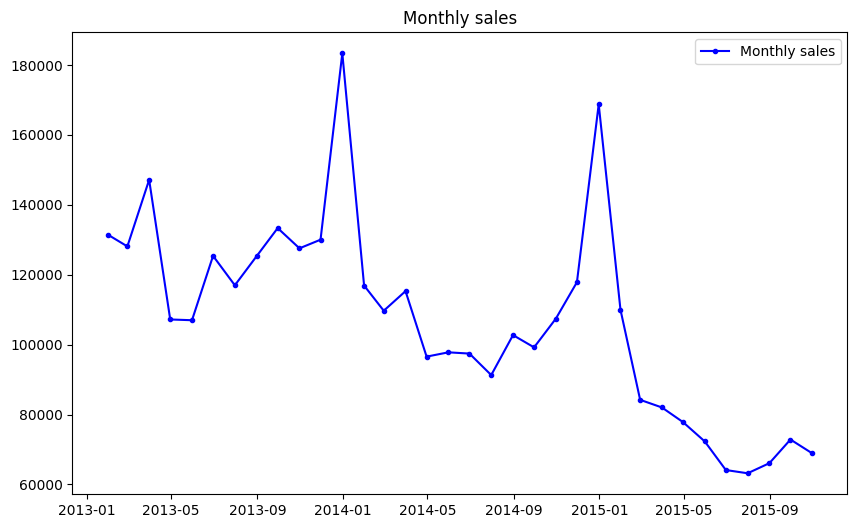

In [45]:
ts_M = full_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_M, color = "blue", label = "Monthly sales",marker='.')
plt.title("Monthly sales")
plt.legend();

We can already see  that the total sales decrease over time and that there is an obvious yearly seasonal pattern with high spikes around Christmas time

<a id = "sales_per_week"></a>
### Total sales per week

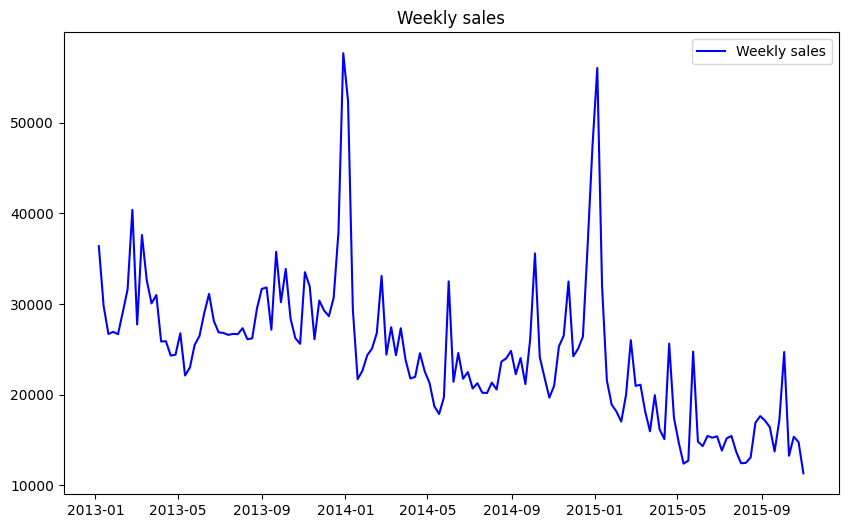

In [48]:
ts_W = full_df[["date", "item_cnt_day"]].set_index("date").resample("W").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_W, color = "blue", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

<a id = "sales_per_month_shop"></a>
### Total sales per month and shop

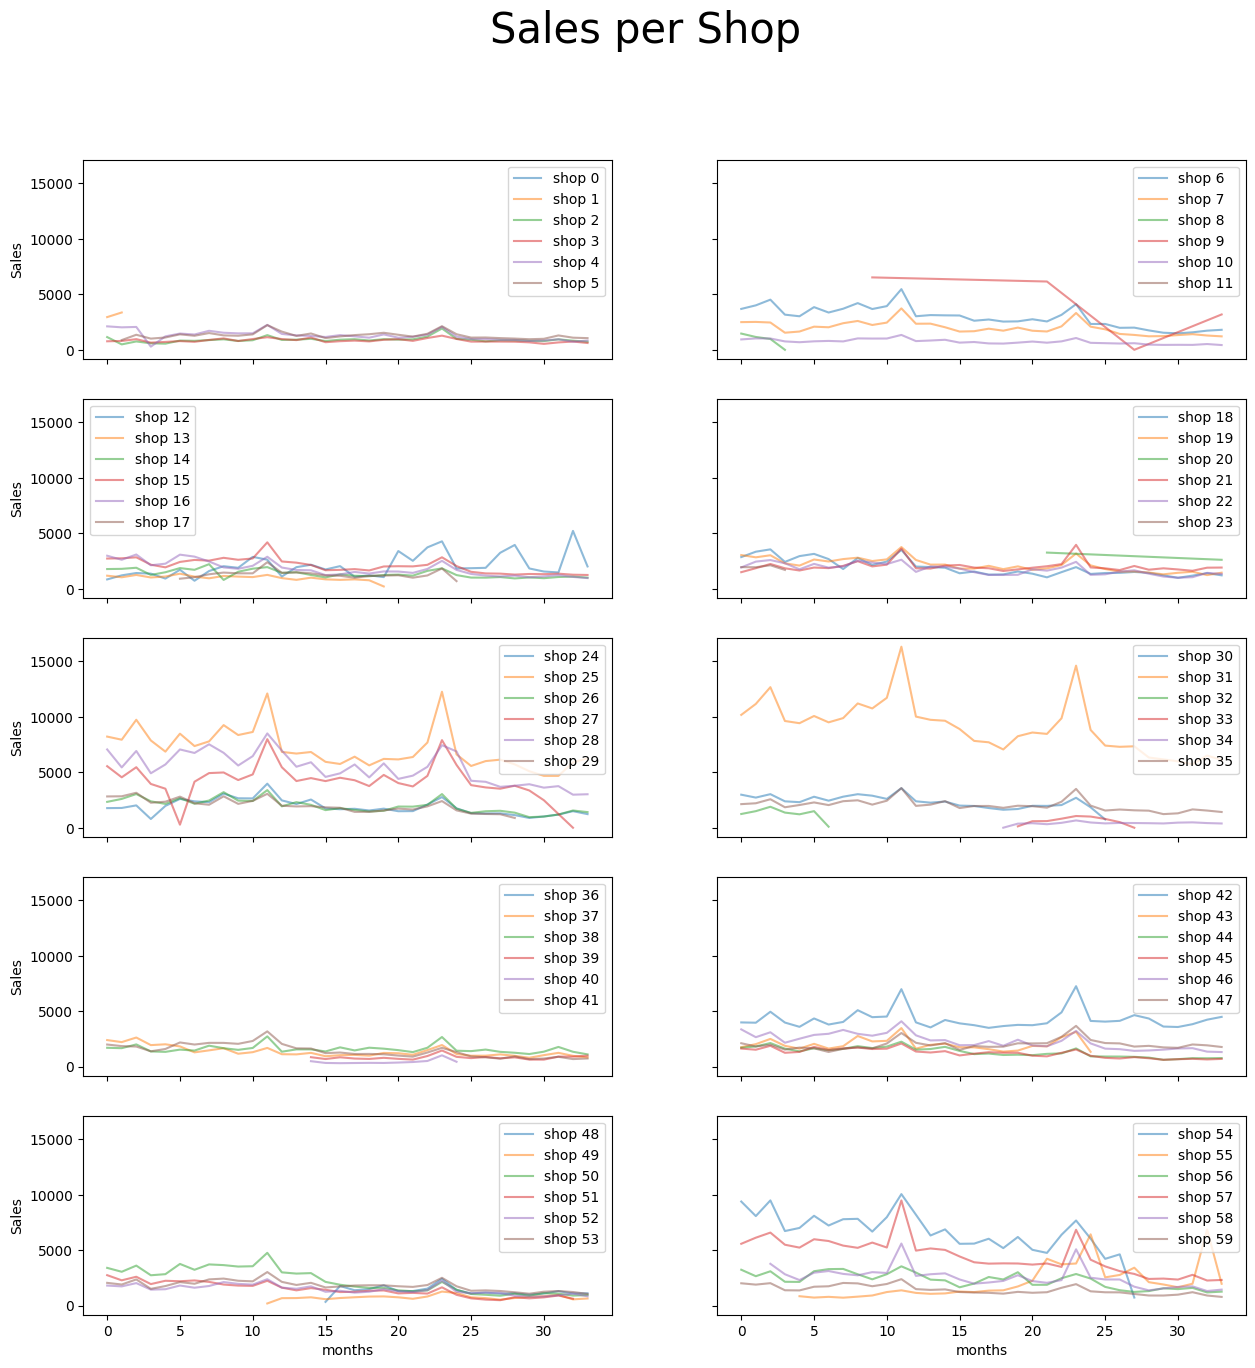

In [49]:
fig,ax = plt.subplots(nrows=5, ncols=2,sharex=True, sharey=True,figsize=(15,15))
fig.suptitle('Sales per Shop', fontsize=30)
ts_shop = full_df.groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()
shop_count=0
for i in range(5):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_shop[ts_shop['shop_id']==shop_count]['date_block_num'],ts_shop[ts_shop['shop_id']==shop_count]['item_cnt_day'],alpha=.5,label='shop '+str(shop_count))
            shop_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

<a id = "sales_per_month_category"></a>
### Total sales per month and category

In [50]:
items_x_cat=full_df.groupby('item_category_id').agg({'item_cnt_day':'sum'})
items_x_cat.reset_index(inplace=True)

In [51]:
items_x_cat=items_x_cat.sort_values('item_cnt_day',ascending=False)
items_x_cat_top=items_x_cat[0:15]
items_x_cat_top['item_category_id']=items_x_cat_top['item_category_id'].astype(object)
items_x_cat_top=items_x_cat_top.reset_index(drop=True)

[Text(0.5, 0, 'item category'), Text(0, 0.5, 'Sales')]

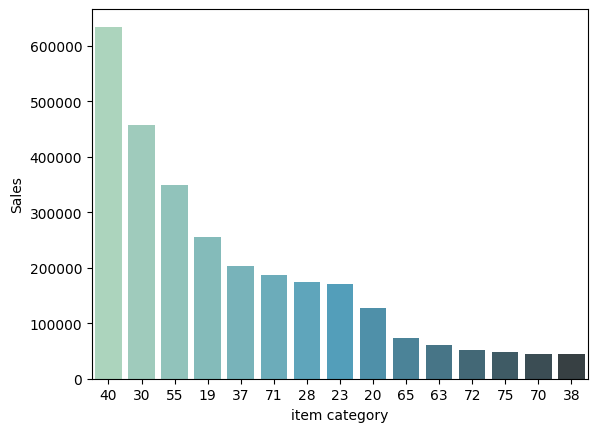

In [52]:
barplot=sns.barplot(y='item_cnt_day',x='item_category_id',palette='GnBu_d',data=items_x_cat_top,order=items_x_cat_top.sort_values('item_cnt_day',ascending=False).item_category_id)
barplot.set(xlabel="item category", ylabel = "Sales")

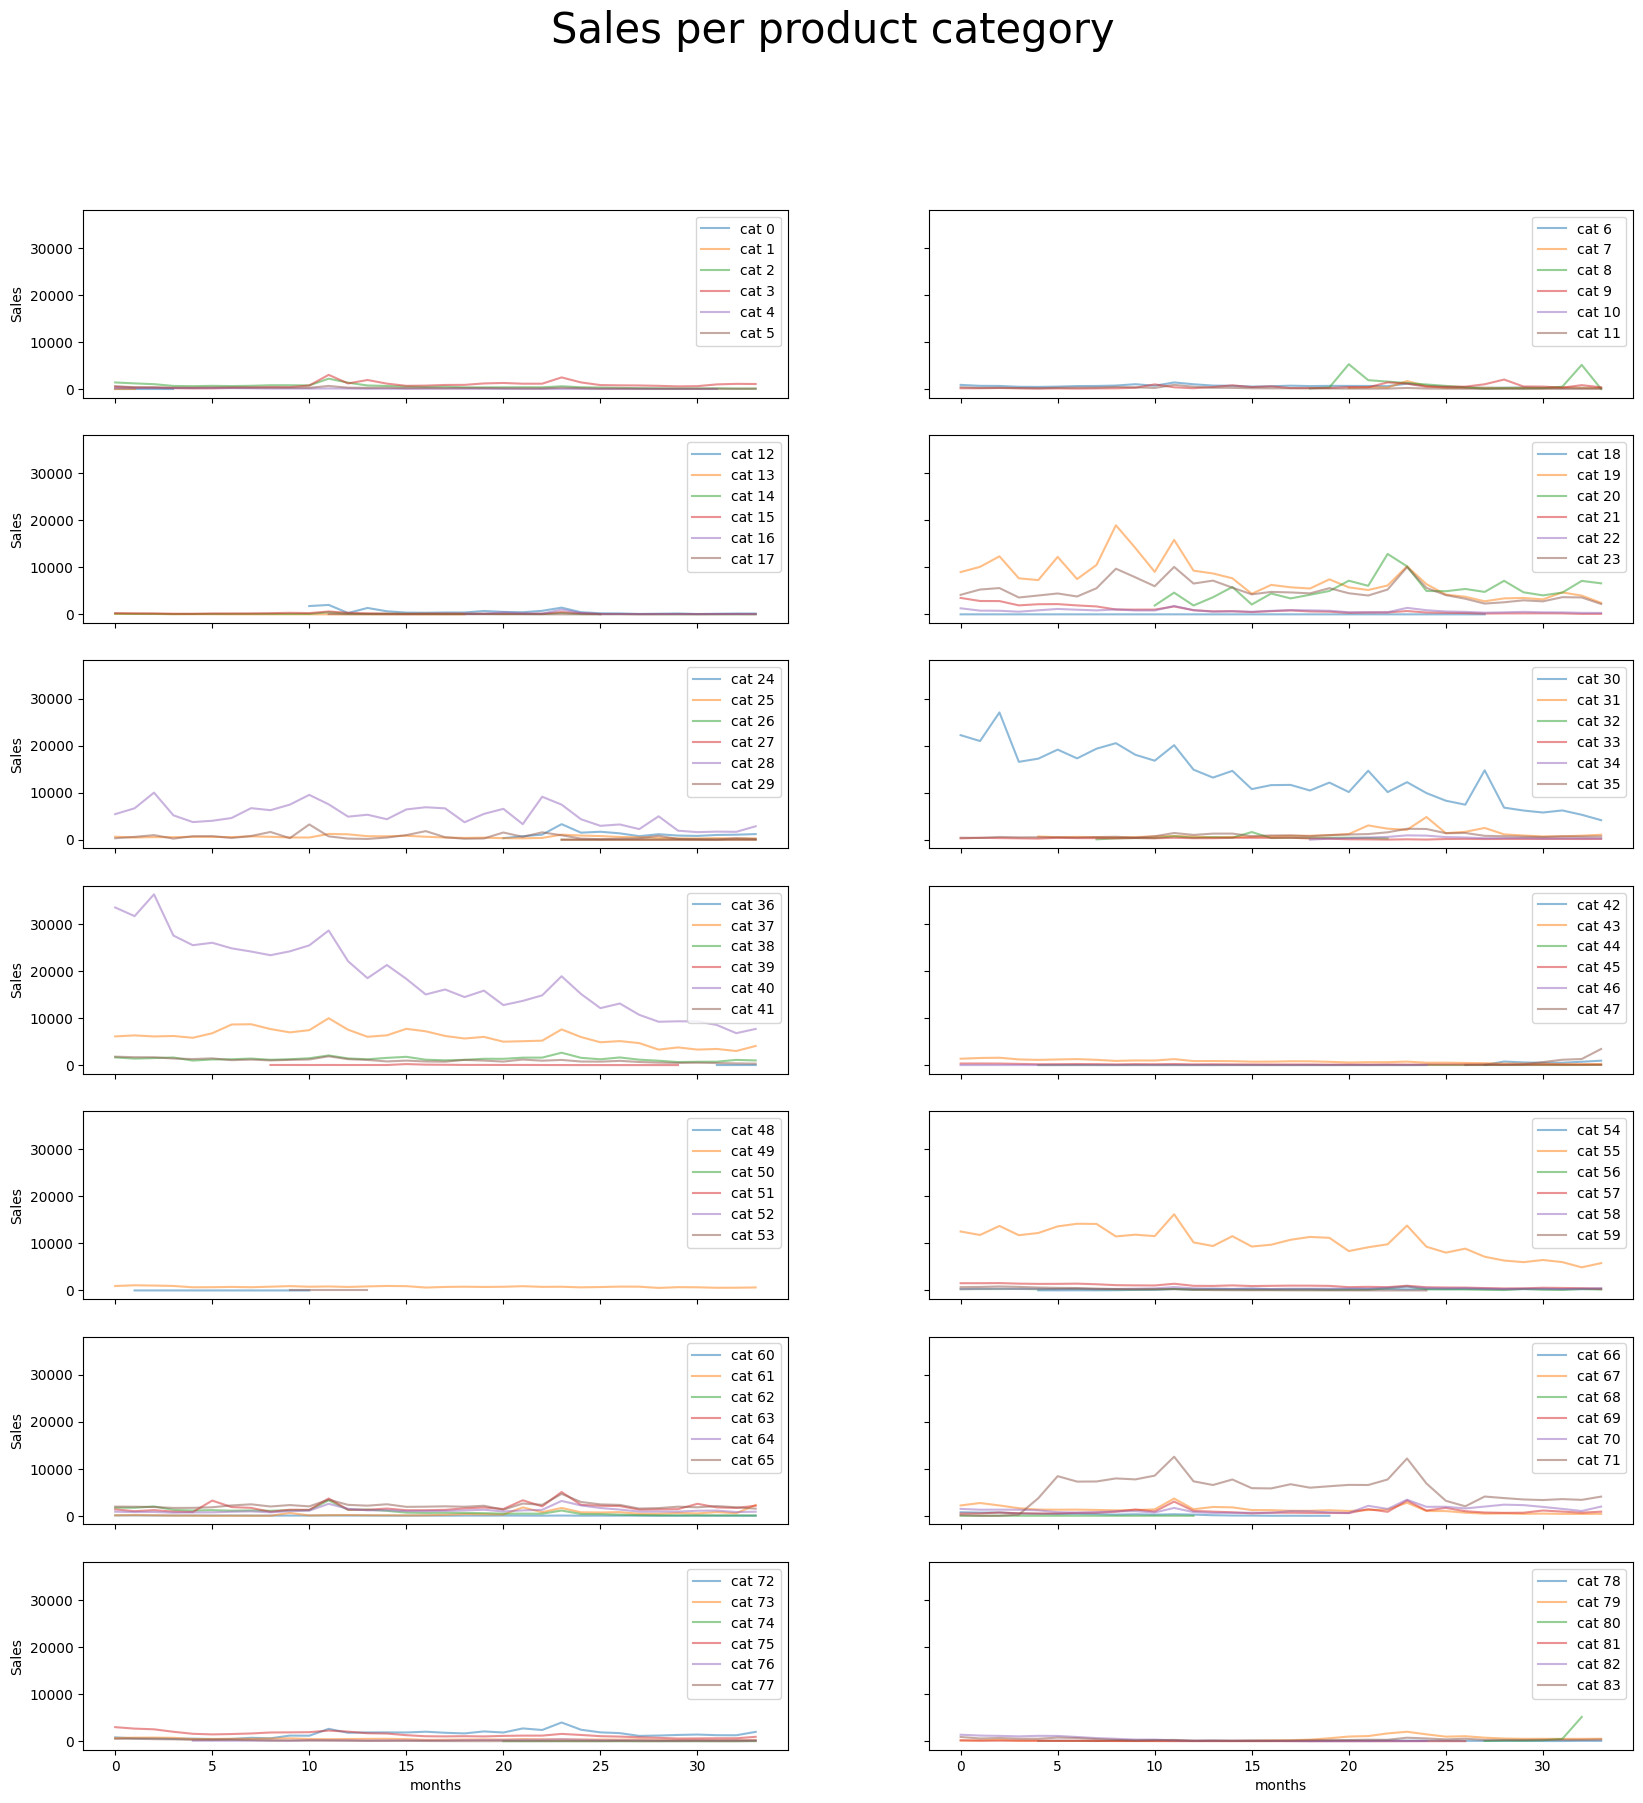

In [53]:
fig,ax = plt.subplots(nrows=7, ncols=2,sharex=True, sharey=True,figsize=(20,20))
fig.suptitle('Sales per product category', fontsize=30)
ts_cat = full_df.groupby(['item_category_id','date_block_num'])['item_cnt_day'].sum().reset_index()
cat_count=0
for i in range(7):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_cat[ts_cat['item_category_id']==cat_count]['date_block_num'],ts_cat[ts_cat['item_category_id']==cat_count]['item_cnt_day'],alpha=.5,label='cat '+str(cat_count))
            cat_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()

<a id = "ts_analysis"></a>
# Time Series Analysis

In this section we are gonna take a look at the main properties of time series. We are gonna check the stationarity of the series, decompose it into its essential components and check how strong the relationship between an observation is with the observations at prior time steps, called lags.

Some of the algorithms that we will be using require the time series to be stationary, so we will have to transform it beforehand.

<a id = "autocorrelation"></a>
### Autocorrelation and partial autocorrelation (ACF and PACF)

This techniques consists in finding how correlated a time series is with itself in prior time steps. We fit the observations in time t with the observations in t-1, t-2 , etc.  In this particular problem, it will allow us to know how correlated the number of sales in a month is to the number of sales the previous month, and to two months before, and so on... There is two effects to take into account: The direct effect and the indirect effect.

Let's imagine we want to check the correlation between time t observations and time t-2 observations. The direct effect will be the correlation between t-2 to t and the correlation between t-1 and t. The indirect correlation would be between t-2 and t-1.

<b>Autocorrelation:</b> Takes into account direct and indirect effects.

<b>Partial autocorrelation:</b> Takes into account only the direct effects.

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 20 must be < 17.

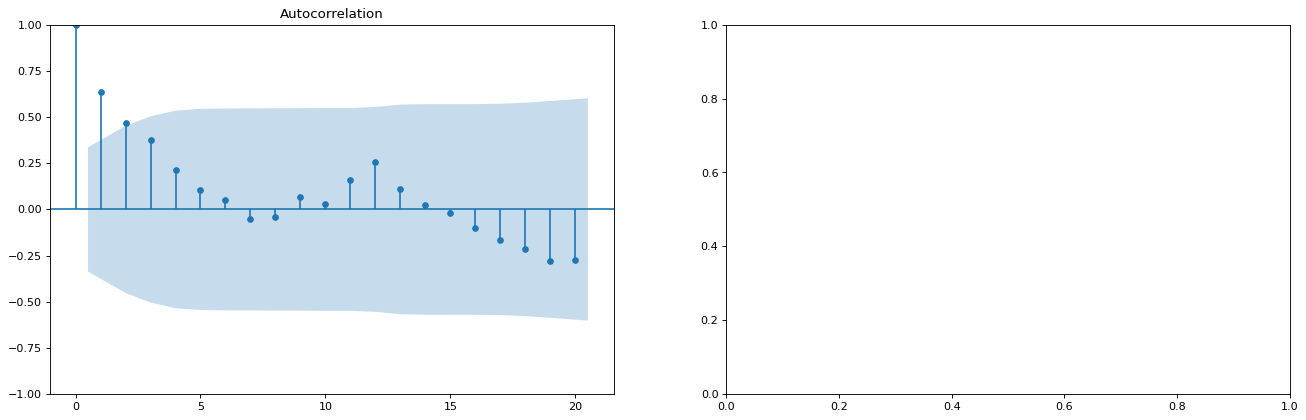

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,6), dpi = 80)
plot_acf(ts_M, ax = ax1, lags = 20)
plot_pacf(ts_M, ax = ax2, lags = 20);

The blue area represents de confidence interval, set to 95% by default. This suggests that lags with values outside of this area are likely correlated. We can se how there is a positive correlation with the first 6 lags and that <b>it is significant for the lags 2 and 3, which means that the sales from the previous two months have a significant correlation with the sales of the present month.</b>

<a id = "decomposing"></a>
### Decomposing the TS

Here we are gonna decompose the ts into its essential compenents, the general trend, seasonal trend and residuals

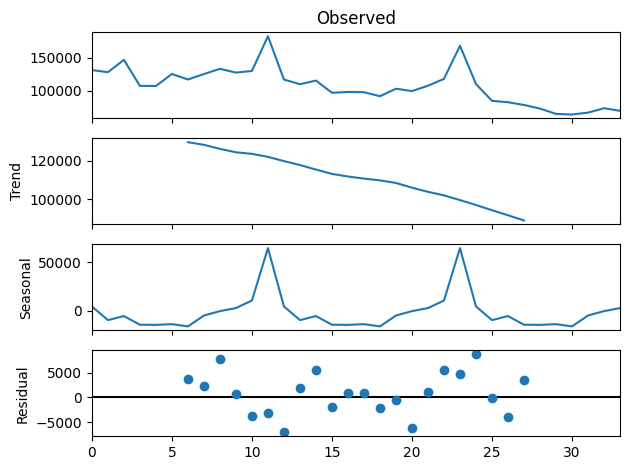

In [56]:
res=seasonal_decompose(ts_M.values,period=12,model='additive')
fig=res.plot()

The trend show us that sales are going down. The seasonal graph removes the trend from the ts and shows us high seasonal spikes around Chritsmas time. The resuals show us what is left of the ts when you remove the trend and the seasonality effects, so hopefully the residuals are small, since we don't want other effects, aside from trend and seasonality to explain the ts

<a id = "stationarity"></a>
### Stationarity Test | Dickey-Fuller

The conditions we need to look at to determine if a ts is stationary are:

 <b>-The mean is constant</b>

 <b>-The standard deviation is constant</b>

 <b>-There is no seasonality</b>

Some forecasting machine learning methods and statistical modeling methods require the ts to be stationary in order to be able to use them, that is without the effects of a trend, seasonality, volatility and other time-dependent structures. We have already seen that the ts we are working with here is not stationary. It has a downward trend and high seasonality. The Dickey-Fuller test gives us a number to measure how far off our ts is from being stationary.

The null hypothesis of the test is that the time series is not stationary and has time-dependent structures of some kind. The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary. It use the p-value to interpret the result. If the p-value > 0.05, we can reject the h0 and the data is non-stationary. If p-value <= 0.05 we can reject the h0 and conclude that the ts is stationary.

In [57]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic:','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [58]:
test_stationarity(ts_M)

Results of Dickey-Fuller Test:
ADF Statistic:                 -2.375595
p-value                         0.148743
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


No surprise here, p-value > 0.05. <b>Ts is non-stationary</b>

<a id = "remove_stationarity"></a>
### Remove Non-Stationarity effects

Let's take a look at the different things we need to do to make a time series stationary

In [59]:
def normalize(ts):
    avg,dev=ts.mean(), ts.std()
    ts=(ts-avg)/dev
    return ts

def remove_seasonality(ts):
    ts= ts-ts.shift(12)
    ts=ts.dropna()
    return ts

def remove_trend(ts):
    ts= ts.diff(1).dropna()
    return ts

Text(0, 0.5, 'Total de ventas')

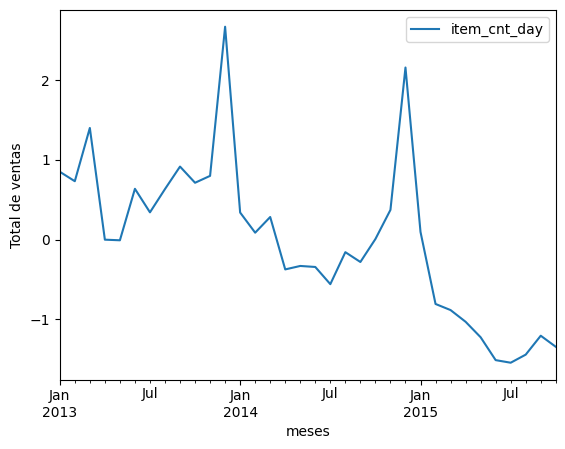

In [60]:
# Normalize TS
ts_norm=normalize(ts_M)
ts_norm.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')

Results of Dickey-Fuller Test:
ADF Statistic:                 -3.188967
p-value                         0.020632
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


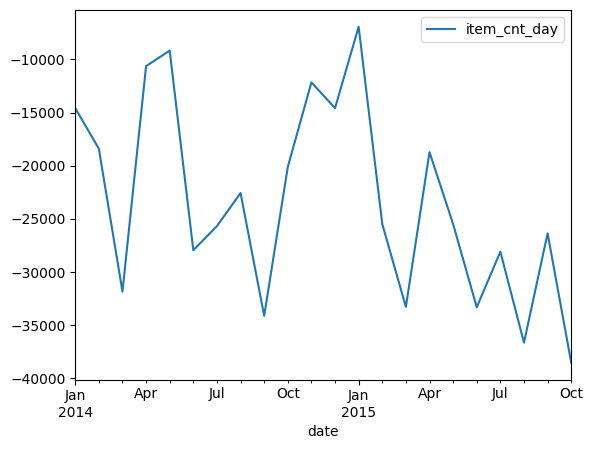

In [61]:
# Remove seasonality
ts_est=remove_seasonality(ts_M)
ts_est.plot()
test_stationarity(ts_est)

Results of Dickey-Fuller Test:
ADF Statistic:                -1.329810e+01
p-value                        7.137961e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


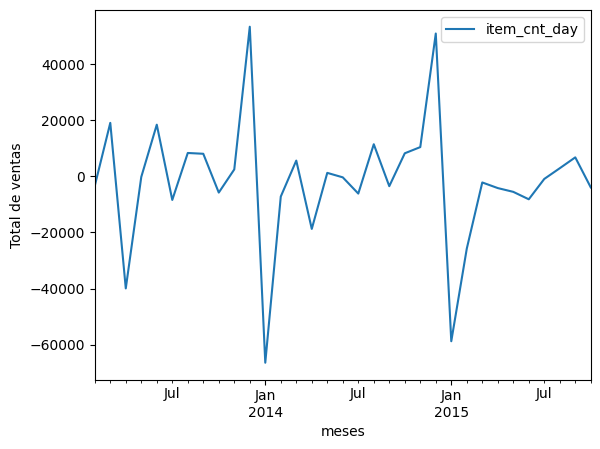

In [62]:
#Remove trend
ts_trend=remove_trend(ts_M)
ts_trend.plot()
plt.xlabel('meses')
plt.ylabel('Total de ventas')
test_stationarity(ts_trend)

<a id = "useful"></a>
### Useful functions

In [63]:
def create_pred_list(X,Y):
    lista_shops=X['shop_id'].tolist()
    preds=[]
    for shop in range(0,len(Y)):
        preds.append(np.array([lista_shops[shop],Y[shop]]))
    return preds

def evaluation(df_pred):
    df_eval=pd.merge(df_valid,df_pred, on=['ID'],how='inner')
    error = sqrt(mean_squared_error(df_eval['obs'].values, df_eval['pred'].values))
    return error

In order to dissagreate the shop forecasts using the <b>TOP-DOWN approach</b> and give every item the proper proportion, we are gonna build the following function to calculate the weight corresponding to each item in each store. <b>We calculate the weights based on the sales of the last 3 months:</b>

In [64]:
def middleout_forecasting(predictions,months_weights):
    month=33-months_weights
    df_forecast=pd.DataFrame(predictions,columns=['shop_id','forecast_shop'])

    #we calculate the number of sales per item in each store of the las "month" months
    sales_gb_item=df_sales[df_sales['date_block_num']>month].groupby(['shop_id','item_id'])["item_cnt_day"].sum()
    sales_gb_item=pd.DataFrame(sales_gb_item)
    sales_gb_item.reset_index(inplace=True)
    sales_gb_item.rename(columns={'item_cnt_day':'item_sales'},inplace=True)

    #we calculate the number of sales store of the las "month" months
    sales_gb_shop=df_sales[df_sales['date_block_num']>month].groupby(['shop_id'])["item_cnt_day"].sum()
    sales_gb_shop=pd.DataFrame(sales_gb_shop)
    sales_gb_shop.reset_index(inplace=True)
    sales_gb_shop.rename(columns={'item_cnt_day':'shop_sales'},inplace=True)

    #we calculate the proportion of the sales for each item in every shop in the last "month" months
    sales_gb_full=pd.merge(sales_gb_item,sales_gb_shop,how='left',on=['shop_id'])
    sales_gb_full=pd.merge(sales_gb_full,df_test,how='left',on=['shop_id','item_id'])
    sales_gb_full['weights']=sales_gb_full['item_sales']/sales_gb_full['shop_sales']
    sales_gb_full.drop(['item_sales','shop_sales'],axis=1,inplace=True)

    #we calculate the forecast for each item in every store
    df_calc=pd.merge(sales_gb_full,df_forecast,how='left',on=['shop_id'])
    df_calc['item_cnt_month']=(df_calc['weights']*df_calc['forecast_shop']).clip(0,20) #clip the result
    df_calc.drop(['shop_id','item_id','weights','forecast_shop'],axis=1,inplace=True)

    return df_calc

<a id = "validationdf"></a>
### Validation df

Before we begin modelling... here we put together a df to validate the results of the models. We will use the last month (october, date_block_num=33) for validation. This df has the format : ['ID','obs']

In [65]:
#df validation, month 33
df_valid=full_df[full_df['date_block_num']==33].groupby(['shop_id','item_id'])["item_cnt_day"].sum().clip(0,20).to_frame()
df_valid.reset_index(inplace=True)

df_valid=pd.merge(df_valid,df_test, on=['shop_id','item_id'],how='left').sort_values('ID')
df_valid.drop(['item_id','shop_id'],axis=1,inplace=True)
df_valid.rename(columns={'item_cnt_day':'obs'},inplace=True)
df_valid=df_valid[['ID','obs']]

KeyError: 'shop_id'

<a id = "approaches"></a>
# Possible approaches

Up to this point, we have extracted some interesting new features from the raw data, we merged it all together and we know the essential characteristics of the time series we are dealing with.

In this section we are gonna explore the underlying intuition behind some comun statistical methods for time series forecasting.

<a id = "hierarchical"></a>
### Hierarchical Time Series

Our ts has 3 levels of hierarchy: total sales, sales per shop and sales per shop and item. In this exercise we are asked to make predictions for the lower hierarchical level, sales per shop and item. This poses a problem since we are working on a personal laptop with not enough computing power to model at the item level. There are to, we are gonna have to work around this issue. We found this [paper published by Rob Hyndman](https://robjhyndman.com/publications/hierarchical-tourism/) with an interesting approach. Without going into too much detail, the idea of the technique is the following:

<b>-Bottom-up approach:</b> Model and predict for the lowest level of the hierarchy and then sum these predictions to produce forecast for the upper levels.

<b>-Top-down approach:</b> Model and predict for the top level of the hierarchy and then disaggregate these down the hierarchy.

<b>-Middle-out approach:</b> It combines bottom-up and top-down. First generates forecasts for a middle level and the apply top-down or bottom-up to generate the forecasts for the lower and upper levels.

<b>We are going to use the Middle-out approach to model and predict at the shop level and then dissagregate to generate the predictions at the shop-item level.</b>

<a id = "approach1"></a>
# Approach 1: ARIMA

ARIMA stands for <b>AutoRegressive Integrated Moving Average</b> . There is 3 components in this model and each one corresponds to a parameter in the ARIMA model implementation in python. ARIMA(p,d,q):

<b>-AR:</b> Autoregression. Takes into account the strength of the relationship between an observation and its previous observation at different lags. It corresponds to the <b>p</b> parameter or the lag order, it is the number of lags included in the model.

<b>-I:</b> Integration. Substracts to the observation the observation at previous timestamps. Useful to make the series stationary.It corresponds to the <b>d</b> parameter or the degree of differencing, it is the number of times we want to substract from the observations.

<b>-MA:</b> Moving Average. Takes into account the strenght of the relationship between an observation and its average in previous timestamps. It corresponds to the <b>q</b> parameter or the window size, it is the number lags we want to take into account to calculate the average.

We can try to make some of the parameters 0 to make AR models (d=q=0) or MA models (p=d=0) or ARMA models (d=0)...

<a id = "arima_quicklook"></a>
### ARIMA - Quick look

Let's first take a look at the results of applying ARIMA to the global monthly sales time series.

Since we have seen previously that the time series is not stationary and requires differencing to remove the seasonality, 1 would be a good value for the parameter q. And since the autocorrelation was significat for the first 2 or 3 lags we can set the p to 3.

In [66]:
ts_arima=remove_seasonality(ts_M)

                               SARIMAX Results                                
Dep. Variable:           item_cnt_day   No. Observations:                   22
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -223.335
Date:                Sun, 24 Nov 2024   AIC                            454.670
Time:                        19:20:53   BIC                            458.848
Sample:                    01-31-2014   HQIC                           455.577
                         - 10-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4399      0.167     -2.640      0.008      -0.767      -0.113
ar.L2         -0.3668      0.174     -2.104      0.035      -0.709      -0.025
ar.L3         -0.0483      0.182     -0.265      0.7

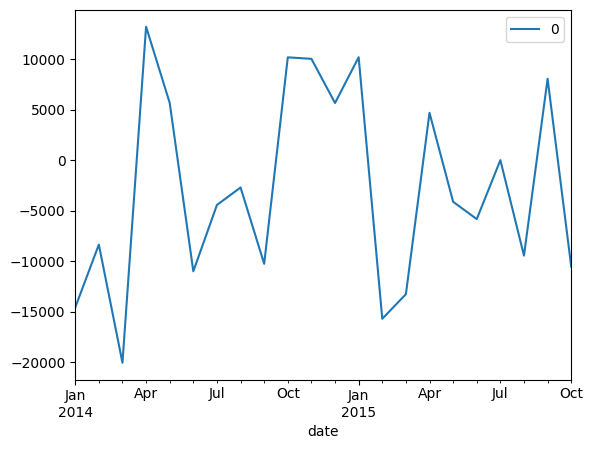

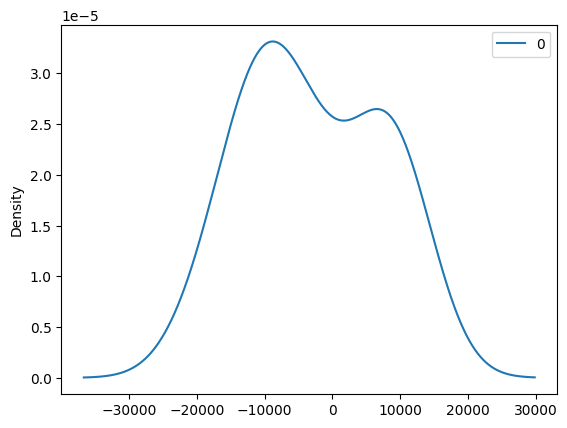

In [73]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_arima, order=(3,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

<a id = "arima_modelling"></a>
### ARIMA - Modelling

In [69]:
# NIVEL DE TIENDA
ts_shop=df_sales.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
ts_shop=ts_shop.unstack(level=1)
ts_shop=ts_shop.fillna(0)

In [70]:
closed_shops=(ts_shop[33:]==0).all()
closed_shops=np.array(closed_shops.index[closed_shops==True])

In [74]:
def train_evaluation_arima(ts,i):
    predictions = list()

    X=ts[i].values
    train, test = X[0:33], X[33:]
    history = [x for x in train]
    print('-----------------------shop %f--------------------------' % i)
    if (i in closed_shops or sum(history)==0):
        for t in range(len(test)):
            	predictions.append(0)
    else:
        for t in range(len(test)):
            model = ARIMA(history, order=(2,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.predict(1, len(history)+1, typ='levels')
            yhat = output[-1]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)

            print('predicted=%f, expected=%f' % (yhat, obs))
            error = sqrt(mean_squared_error(test, predictions))
            print('Test MSE: %.3f' % error)

            plt.plot(history,label='obs')
            plt.plot(output, label='pred',ls='--')
            plt.xticks(range(0,len(history)+1))
            plt.legend()
            plt.title('shop '+str(i))
            plt.show()

    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

In [81]:
lista_pred_arima=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima.append(train_evaluation_arima(ts_shop,i))

-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------


TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

In [ ]:
df_pred_arima=middleout_forecasting(lista_pred_arima,3)
df_pred_arima.rename(columns={'item_cnt_month':'pred'},inplace=True)

Error evaluation:

In [ ]:
error_arima = evaluation(df_pred_arima)
print('Test MSE: %.3f' % error_arima)

Test MSE: 1.643


<a id = "arima_prediction"></a>
### ARIMA - Forecasting

In [78]:
def forecast_arima_shops(ts,i):
    predictions = list()
    train=ts[i].values

    if (i in closed_shops or sum(train)==0):
        predictions.append(0)
    else:
        model = ARIMA(train, order=(2,1,0))
        model_fit = model.fit()
        output = model_fit.predict(1, len(train)+1, typ='levels')
        yhat = output[-1]
        predictions.append(yhat)

        plt.plot(train,label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()

    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

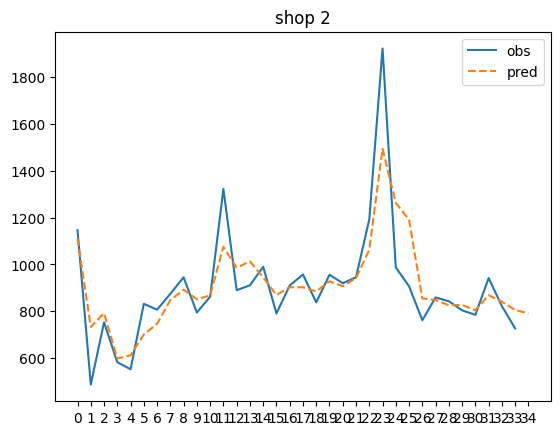

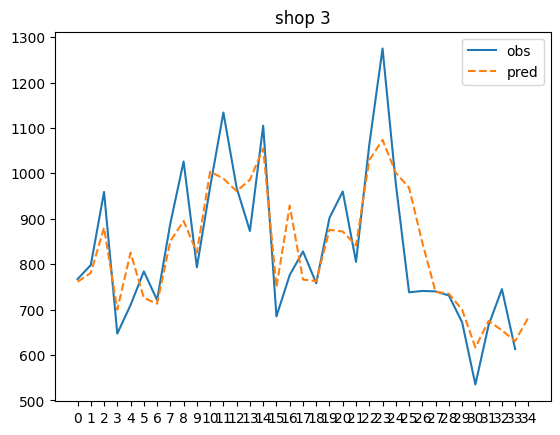

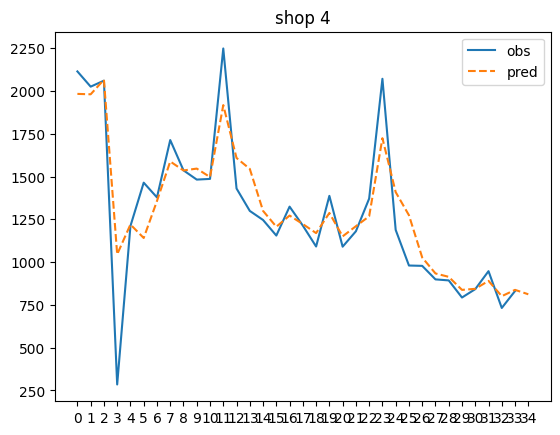

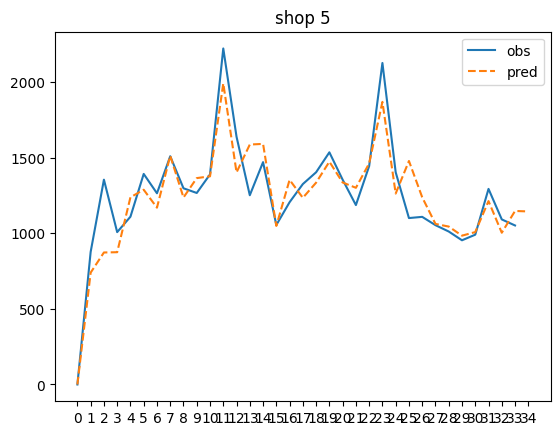

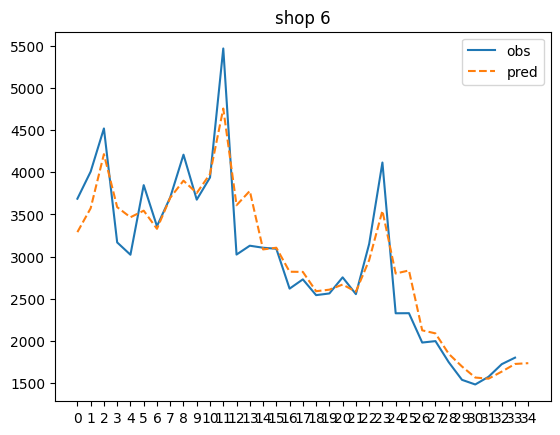

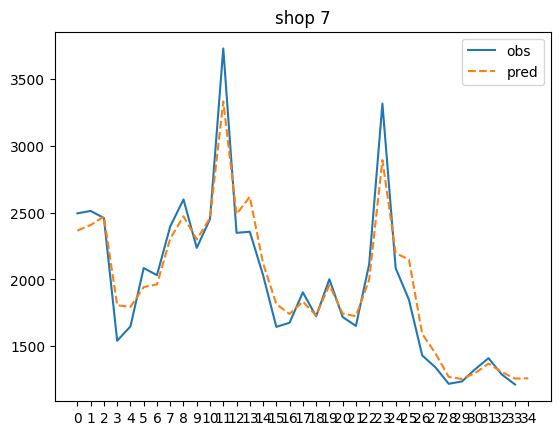

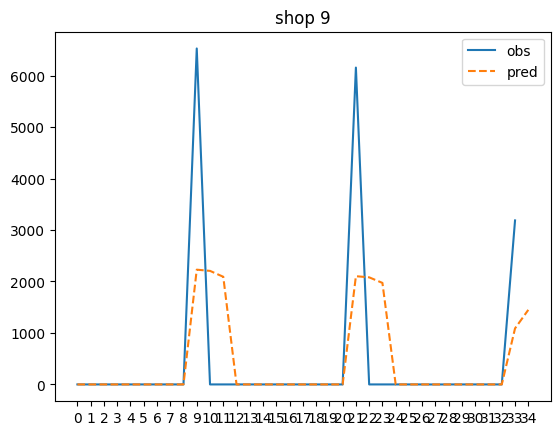

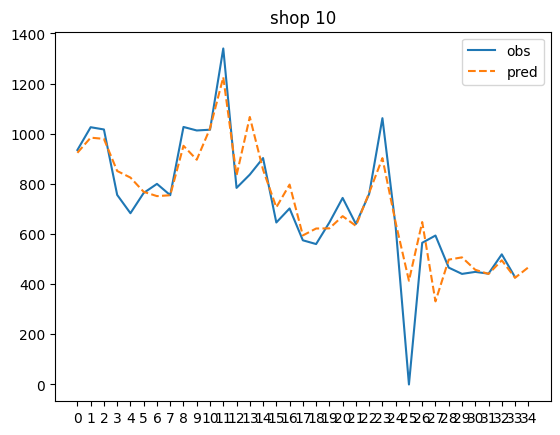

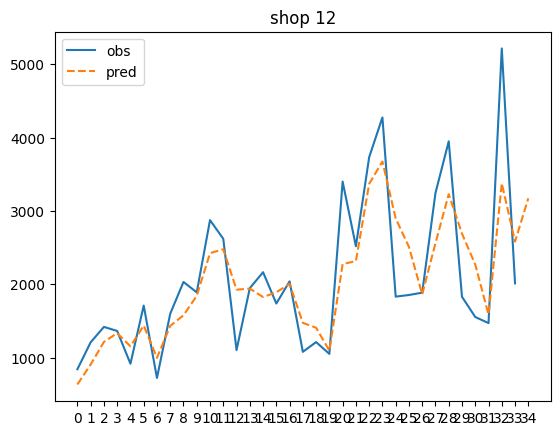

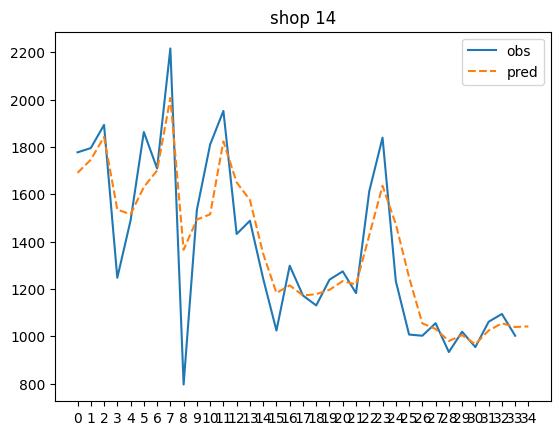

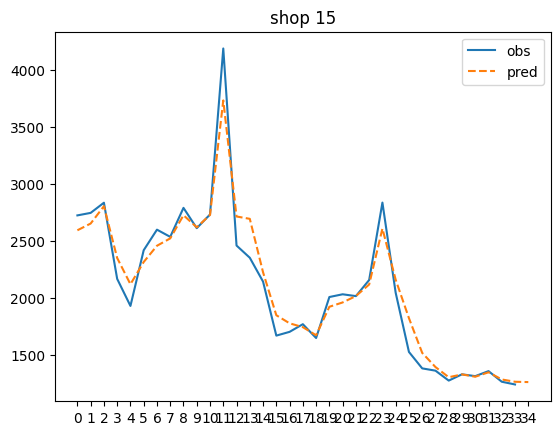

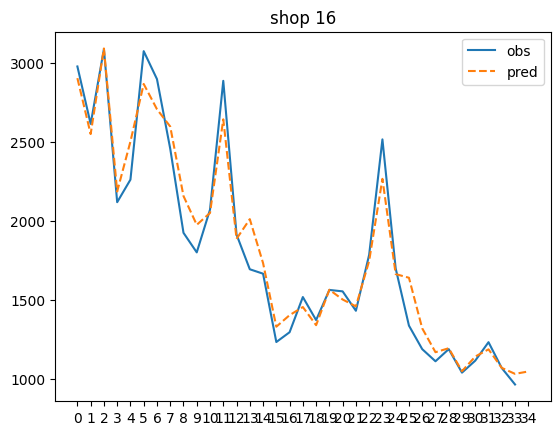

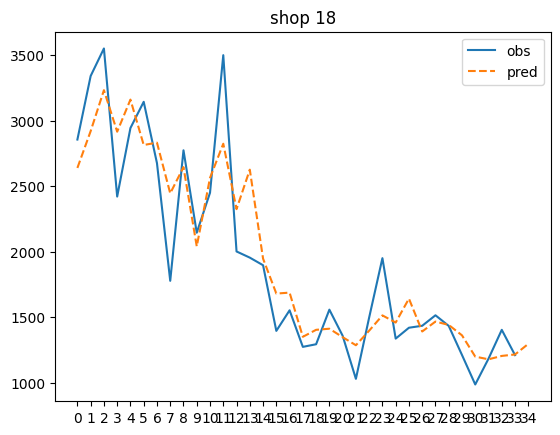

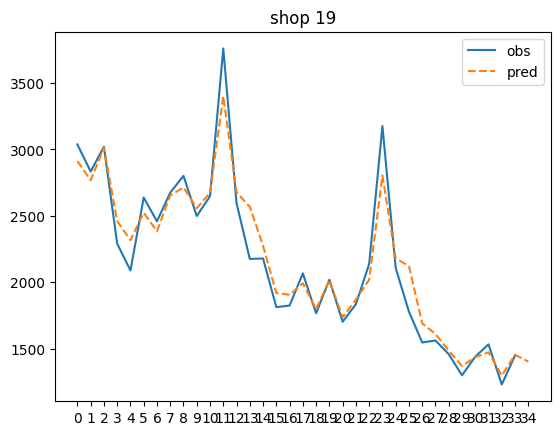

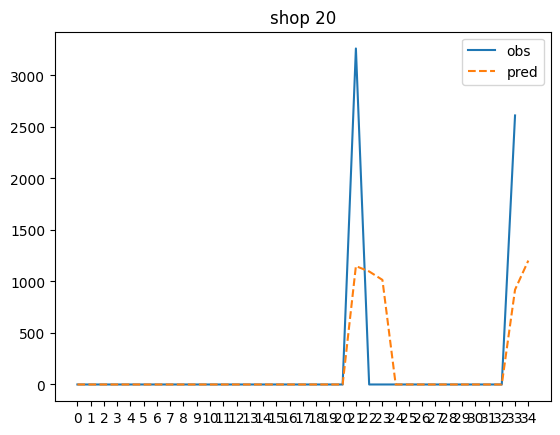

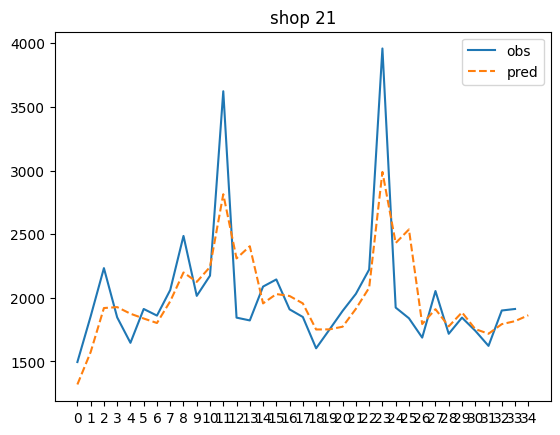

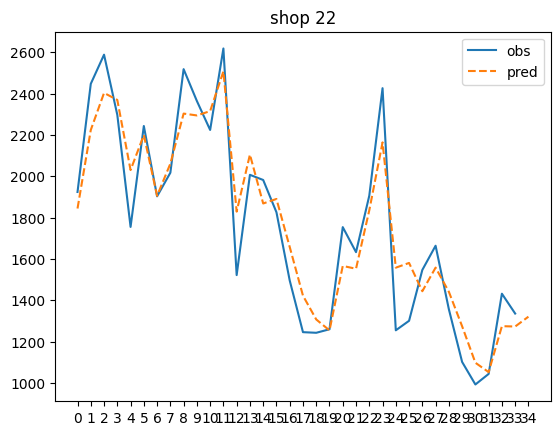

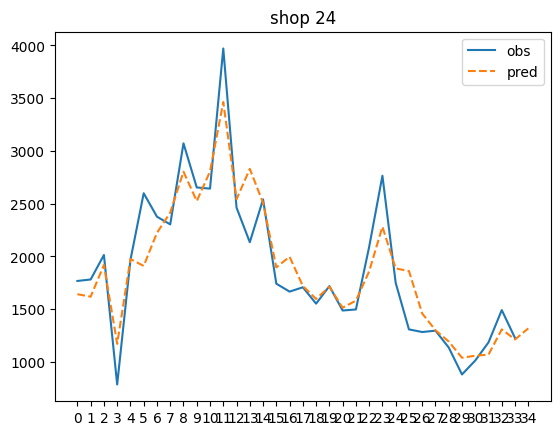

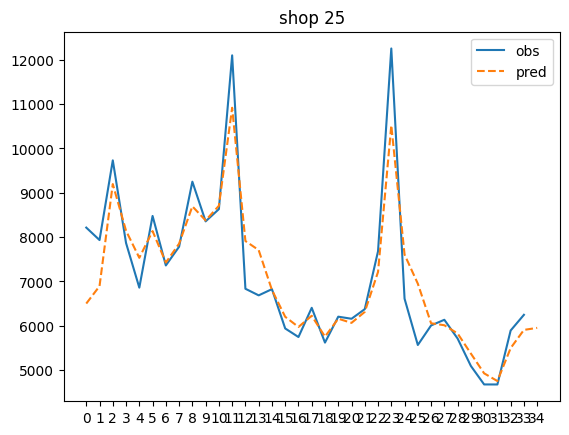

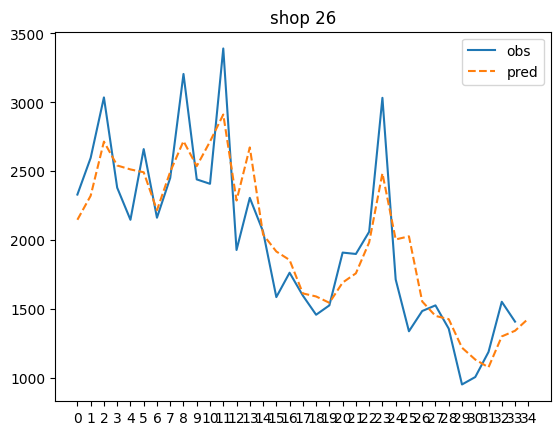

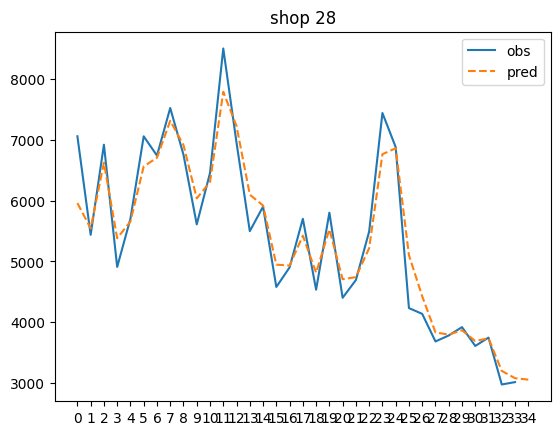

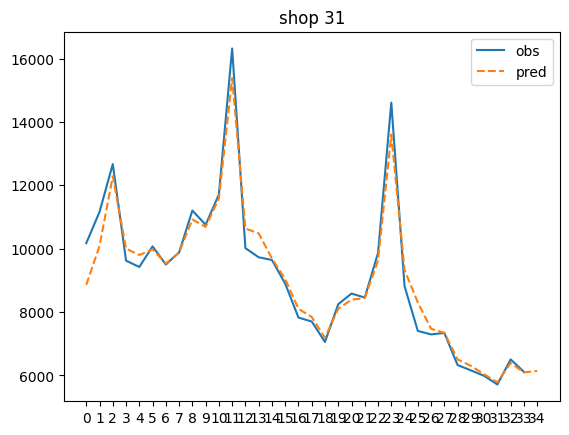

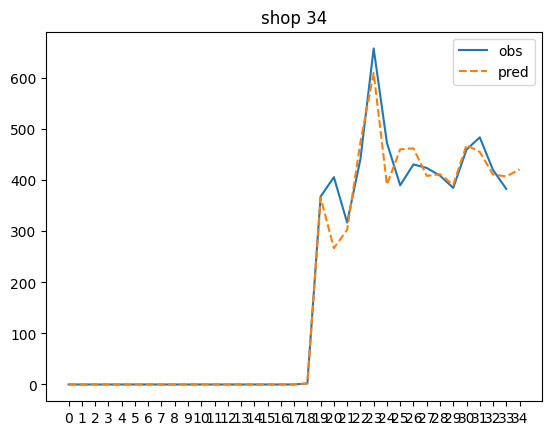

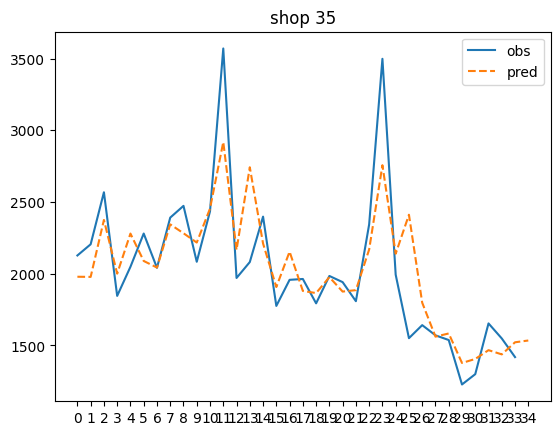

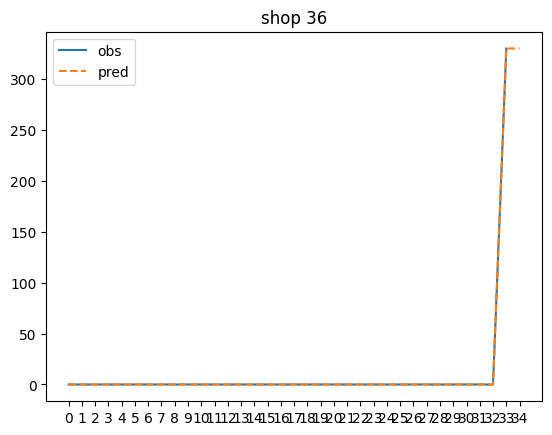

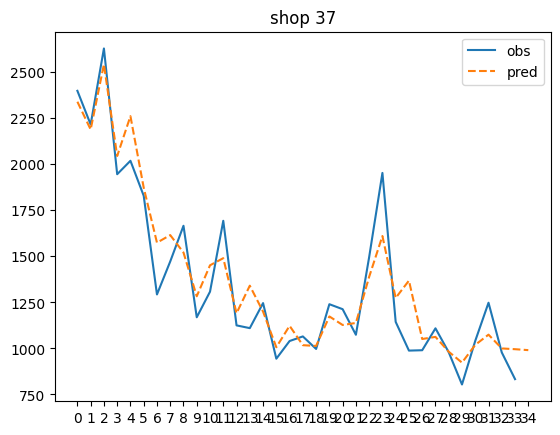

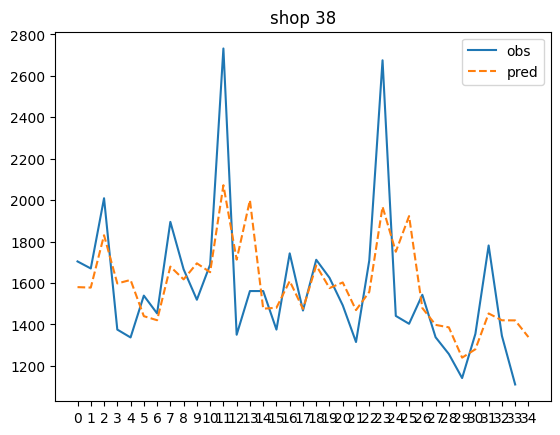

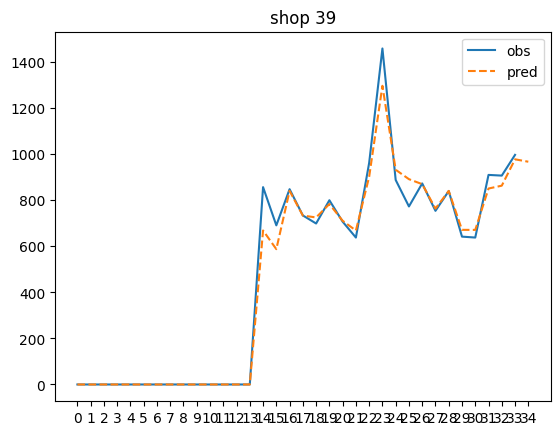

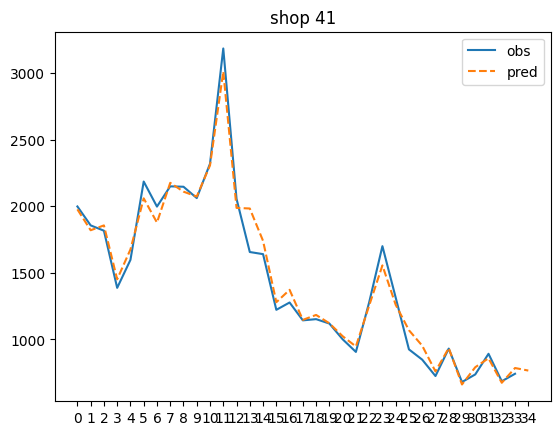

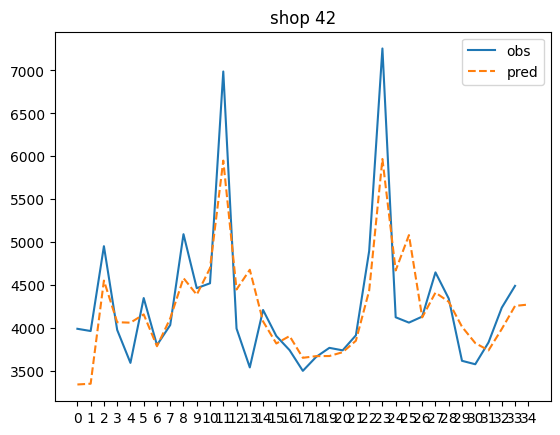

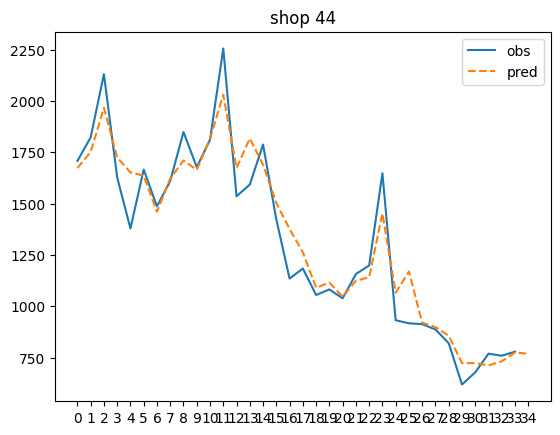

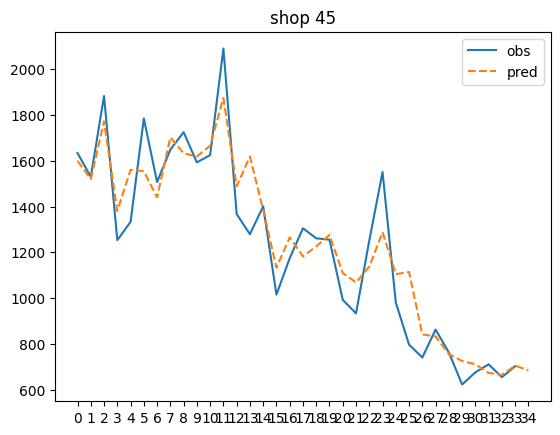

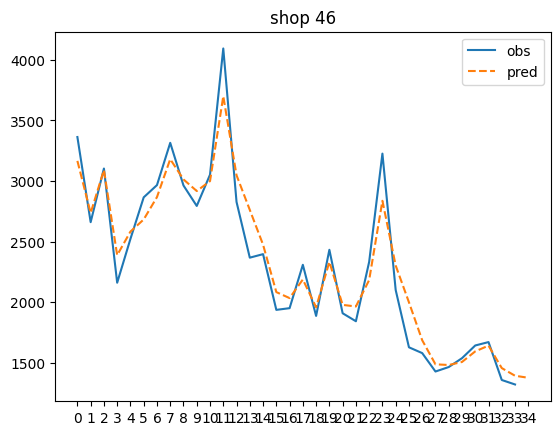

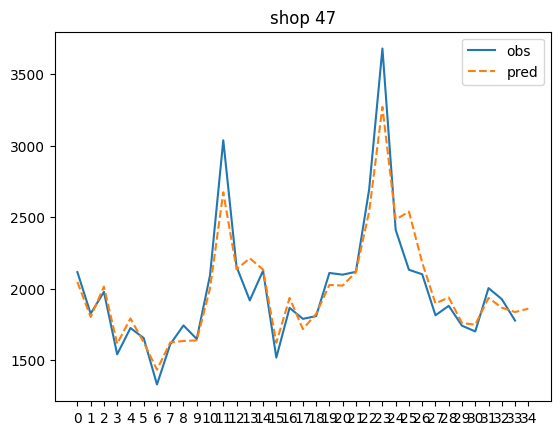

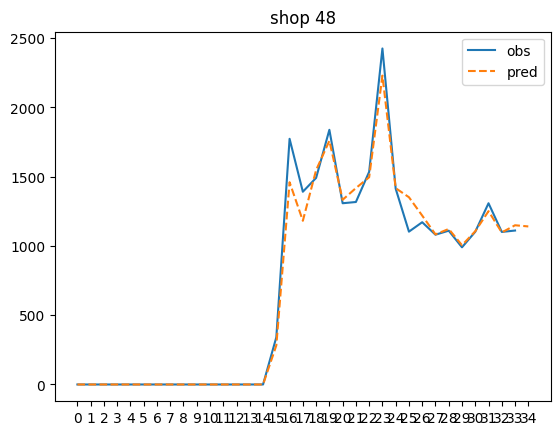

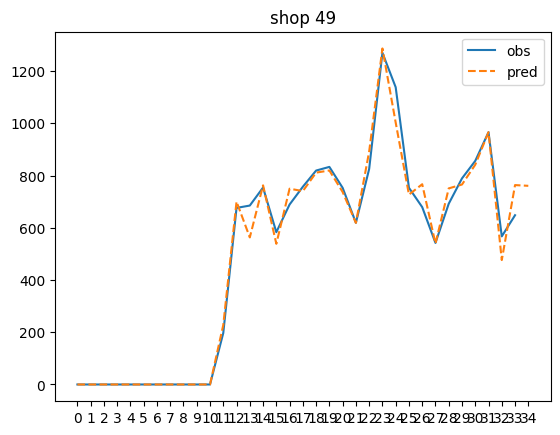

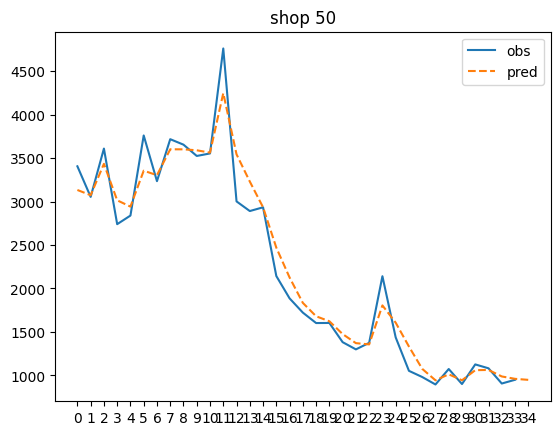

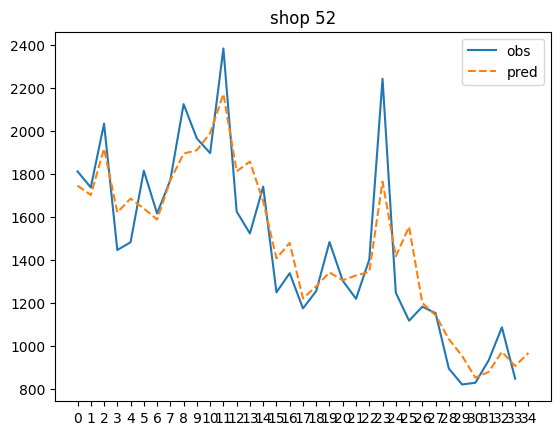

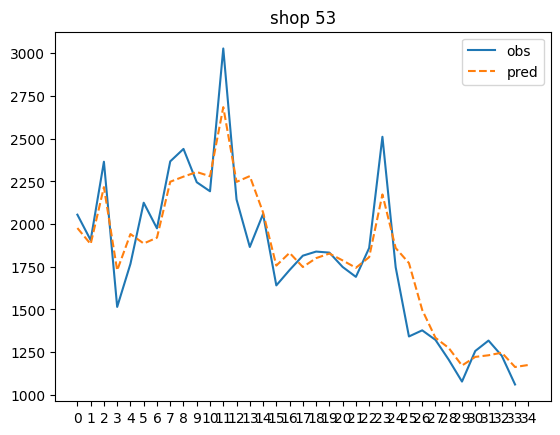

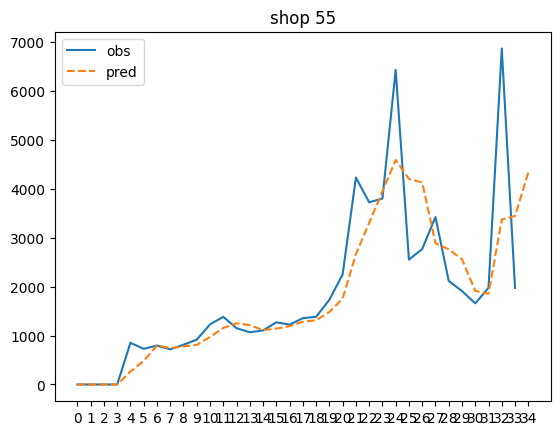

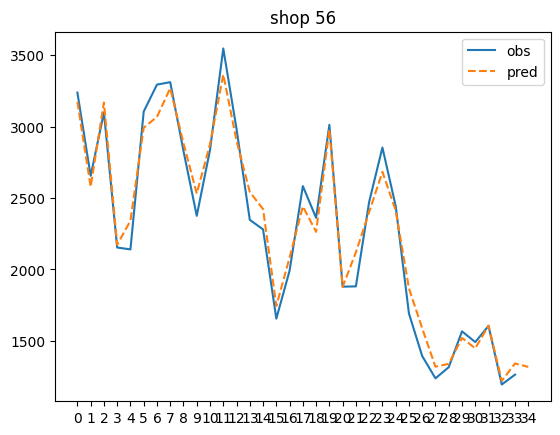

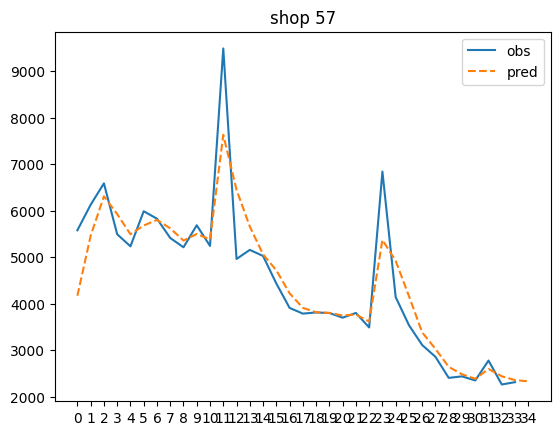

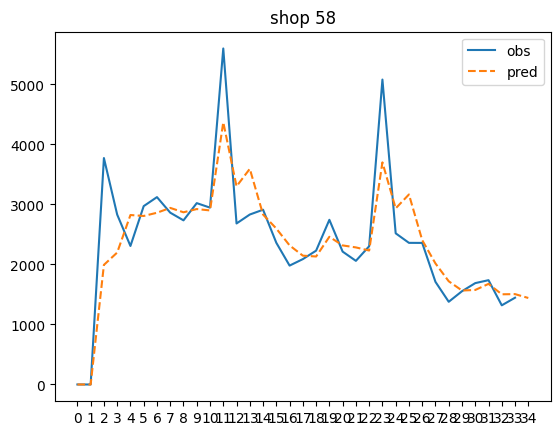

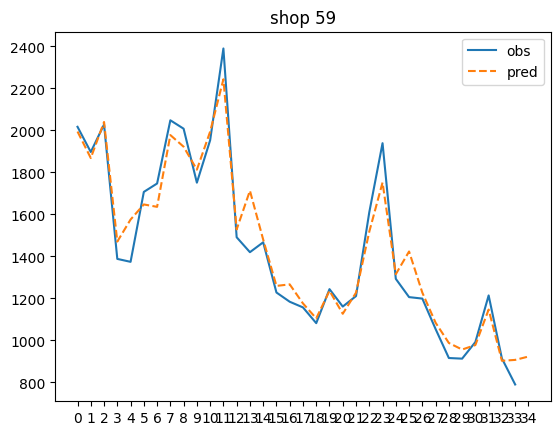

In [79]:
lista_pred_arima_test=[]
for i in ts_shop.columns.tolist():
    lista_pred_arima_test.append(forecast_arima_shops(ts_shop,i))

In [80]:
df_forecast_items=middleout_forecasting(lista_pred_arima_test,3)

KeyError: 'shop_id'

<a id = "approach2"></a>
# Approach 2: Prophet

We will explore this new forecasting procedure developed by Facebook. It is relatively simple to use and could be an interesting approach.

It seems to work reasonably well on messy data, it is robust to outliers and missing data and it is fast.

<a id = "prophet_prepro"></a>
### Prophet - Data prepocessing

In [82]:
ts_prophet=full_df.groupby(["date_block_num"])["item_cnt_day"].sum()

ts_prophet.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts_prophet=ts_prophet.reset_index()
ts_prophet.columns=['ds','y']

<a id = "prophet_quicklook"></a>
### Prophet - Quick look

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/53dbh688.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/18wxuvok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96115', 'data', 'file=/tmp/tmphfek2m2h/53dbh688.json', 'init=/tmp/tmphfek2m2h/18wxuvok.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelsdu1zxwn/prophet_model-20241124192330.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


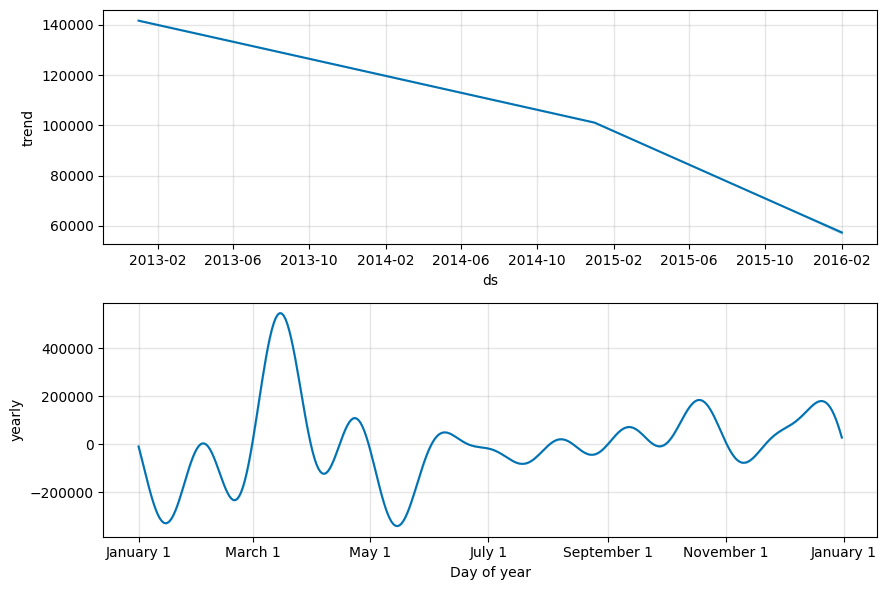

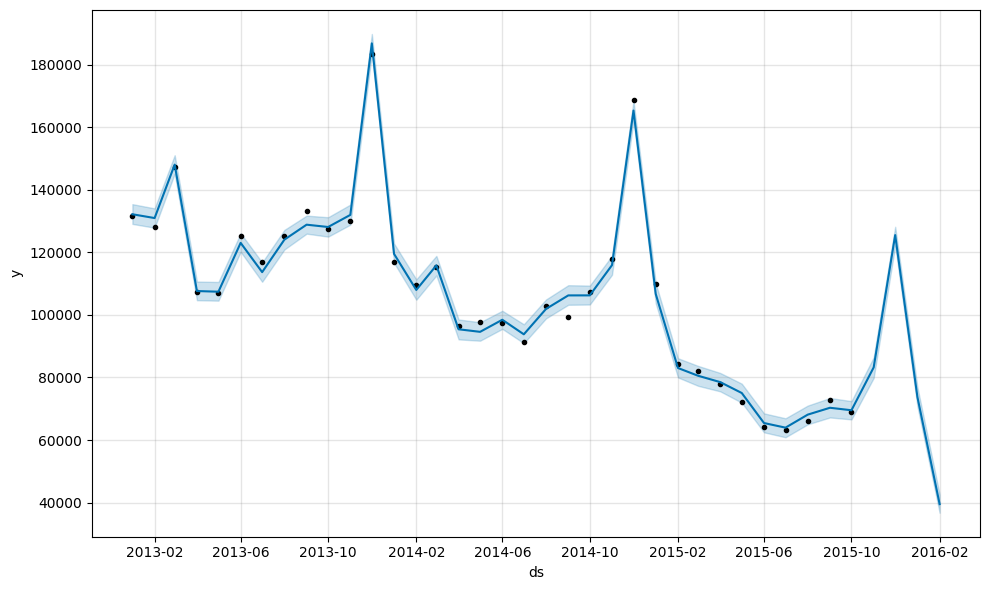

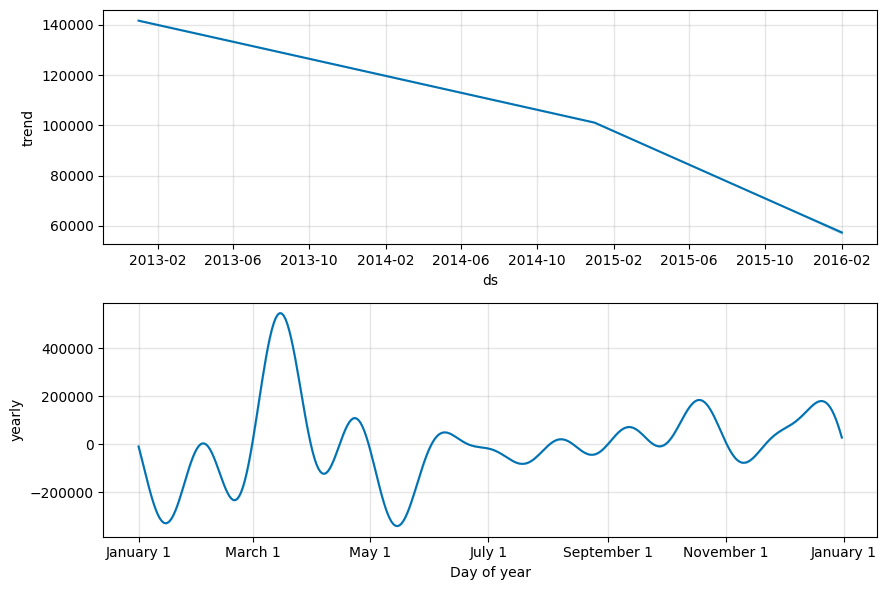

In [83]:
model = Prophet(yearly_seasonality=True)
model.fit(ts_prophet)
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 4, freq = 'MS',include_history=True)
# now lets make the forecasts
forecast = model.predict(future)
#Let's plot the forecast
model.plot(forecast)
#decompose the forecast
model.plot_components(forecast)

<a id = "prophet_model"></a>
### Prophet - Modelling

In [84]:
ts_prophet_shop=full_df.groupby(["date",'shop_id'])["item_cnt_day"].sum()
ts_prophet_shop=ts_prophet_shop.unstack(level=1)
ts_prophet_shop=ts_prophet_shop.fillna(0)
ts_prophet_shop = ts_prophet_shop.resample("M").sum()

In [85]:
def train_evaluation_Prophet(ts,i):
    predictions = list()
    ts=pd.DataFrame(ts[i]).reset_index()
    ts.columns=['ds','y']

    train = ts.loc[ts['ds'] != datetime(2015, 10, 31)]
    test = ts.loc[ts['ds'] == datetime(2015, 10, 31)]
    print('-----------------------shop %f--------------------------' % i)

    if (i in closed_shops or sum(train['y'].values)==0):
        predictions.append(0)
    else:
        model = Prophet(yearly_seasonality=True)
        model.fit(train)
        future = model.make_future_dataframe(periods = 1, freq = 'MS',include_history=True)
        forecast = model.predict(future)
        output = forecast['yhat']
        yhat = output.values[-1]
        predictions.append(yhat)

        print('predicted=%f, expected=%f' % (yhat, test['y'].values))
        error = sqrt(mean_squared_error(test['y'], predictions))
        print('Test MSE: %.3f' % error)

#         model.plot(forecast)
        plt.plot(ts['y'],label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()

    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/snx25p6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/z9bierbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5924', 'data', 'file=/tmp/tmphfek2m2h/snx25p6x.json', 'init=/tmp/tmphfek2m2h/z9bierbn.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model5cxkjazd/prophet_model-20241124192347.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 1.000000--------------------------
-----------------------shop 2.000000--------------------------


19:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1217.916588, expected=727.000000
Test MSE: 490.917


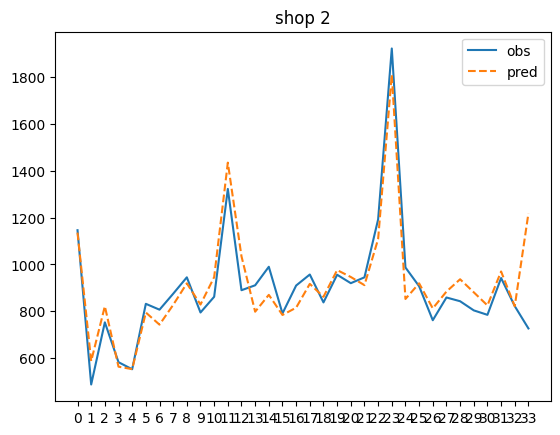

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/5irrrnqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/bloy5mfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24909', 'data', 'file=/tmp/tmphfek2m2h/5irrrnqr.json', 'init=/tmp/tmphfek2m2h/bloy5mfm.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelv5f2x786/prophet_model-20241124192347.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 3.000000--------------------------
predicted=963.257841, expected=613.000000
Test MSE: 350.258


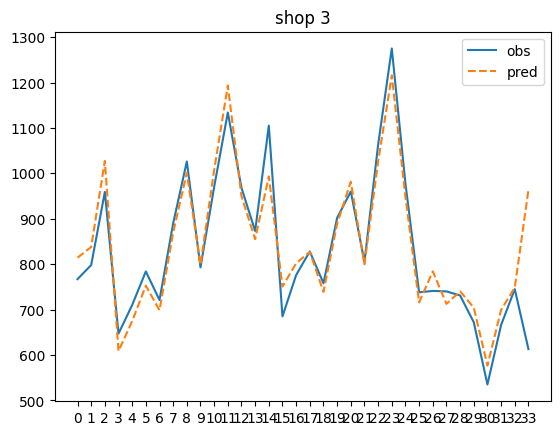

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/xpgbi48v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/2_r1buw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3324', 'data', 'file=/tmp/tmphfek2m2h/xpgbi48v.json', 'init=/tmp/tmphfek2m2h/2_r1buw5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelhn5egr9n/prophet_model-20241124192348.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 4.000000--------------------------
predicted=1287.194252, expected=831.000000
Test MSE: 456.194


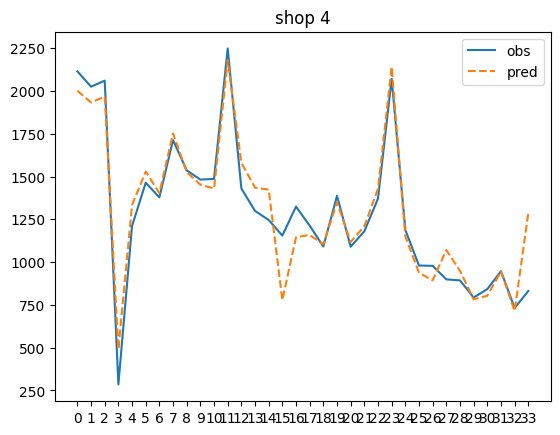

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/y39b3ap3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/63srnv62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=461', 'data', 'file=/tmp/tmphfek2m2h/y39b3ap3.json', 'init=/tmp/tmphfek2m2h/63srnv62.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelsls3eojd/prophet_model-20241124192348.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 5.000000--------------------------


19:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1149.540871, expected=1052.000000
Test MSE: 97.541


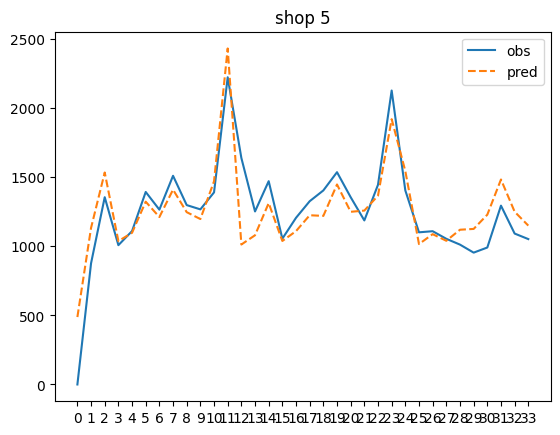

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/to0yf7mp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/gi74rzzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46710', 'data', 'file=/tmp/tmphfek2m2h/to0yf7mp.json', 'init=/tmp/tmphfek2m2h/gi74rzzd.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelqrdgy_8l/prophet_model-20241124192349.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 6.000000--------------------------


19:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=2526.340453, expected=1802.000000
Test MSE: 724.340


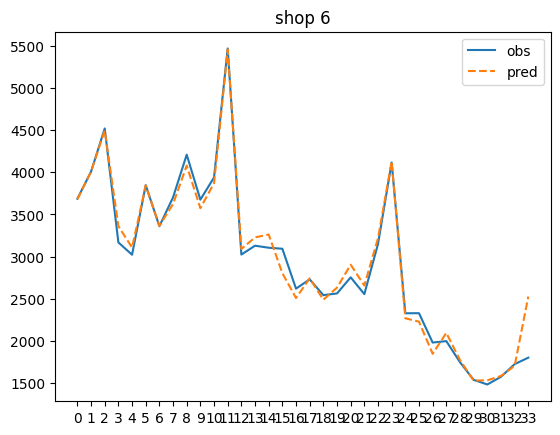

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/qrctfn2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4r5_z_11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68717', 'data', 'file=/tmp/tmphfek2m2h/qrctfn2q.json', 'init=/tmp/tmphfek2m2h/4r5_z_11.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelxhg210xk/prophet_model-20241124192349.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 7.000000--------------------------
predicted=1978.662073, expected=1212.000000
Test MSE: 766.662


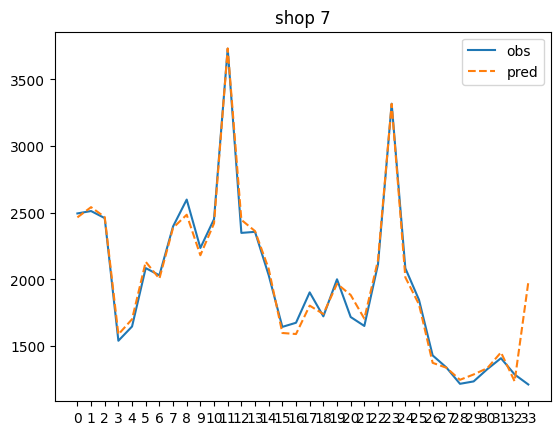

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/5nv6ph_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/31_7t9lq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4296', 'data', 'file=/tmp/tmphfek2m2h/5nv6ph_r.json', 'init=/tmp/tmphfek2m2h/31_7t9lq.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelzgygcqy0/prophet_model-20241124192350.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:23:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 8.000000--------------------------
-----------------------shop 9.000000--------------------------


19:24:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=-368.156689, expected=3186.000000
Test MSE: 3554.157


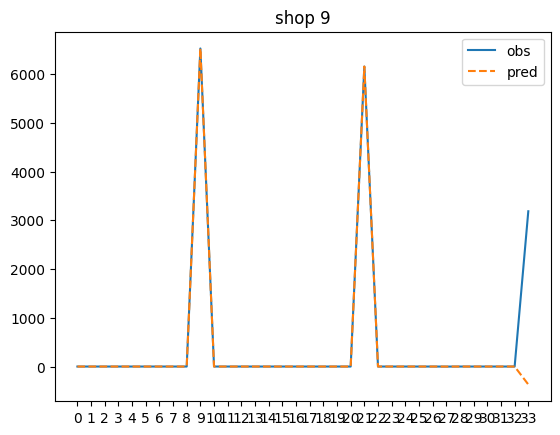

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/nb4lrky1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/u52s8mn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83591', 'data', 'file=/tmp/tmphfek2m2h/nb4lrky1.json', 'init=/tmp/tmphfek2m2h/u52s8mn4.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelspgs72ir/prophet_model-20241124192406.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 10.000000--------------------------


19:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=734.712490, expected=428.000000
Test MSE: 306.712


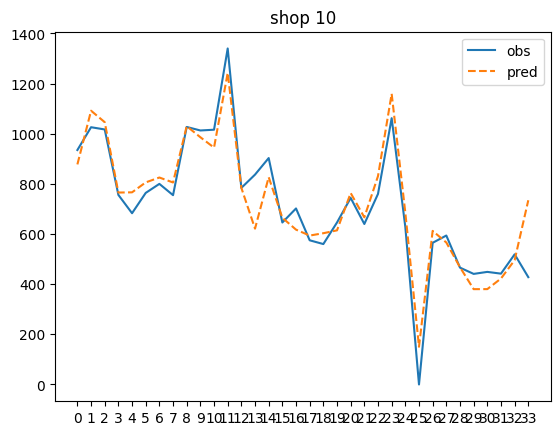

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/1oihzmje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/efpowrv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43127', 'data', 'file=/tmp/tmphfek2m2h/1oihzmje.json', 'init=/tmp/tmphfek2m2h/efpowrv5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model62nu26hl/prophet_model-20241124192406.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 11.000000--------------------------
-----------------------shop 12.000000--------------------------
predicted=1568.855351, expected=2012.000000
Test MSE: 443.145


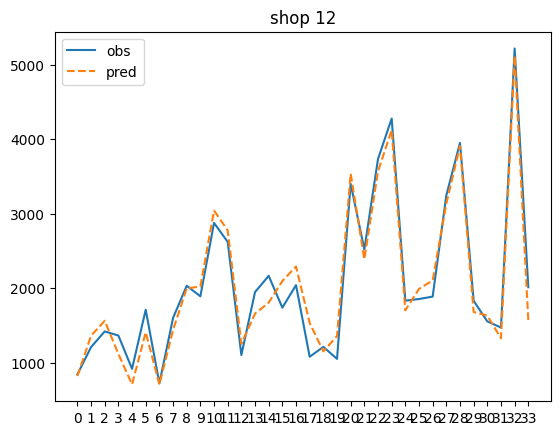

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/na92r4jh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/7zh_m6hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65307', 'data', 'file=/tmp/tmphfek2m2h/na92r4jh.json', 'init=/tmp/tmphfek2m2h/7zh_m6hl.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelu6a289z_/prophet_model-20241124192407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 13.000000--------------------------
-----------------------shop 14.000000--------------------------


19:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=-560.494601, expected=1002.000000
Test MSE: 1562.495


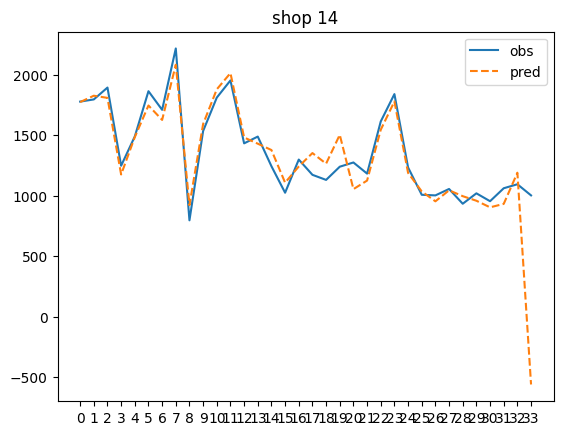

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/pj3a03kp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/r3gi69dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25792', 'data', 'file=/tmp/tmphfek2m2h/pj3a03kp.json', 'init=/tmp/tmphfek2m2h/r3gi69dl.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelne9bo0vv/prophet_model-20241124192407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 15.000000--------------------------
predicted=2093.664413, expected=1243.000000
Test MSE: 850.664


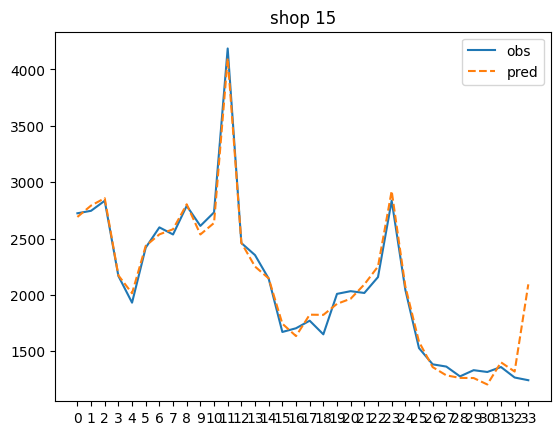

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/_ueoyj3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/uonuhikn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47664', 'data', 'file=/tmp/tmphfek2m2h/_ueoyj3s.json', 'init=/tmp/tmphfek2m2h/uonuhikn.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model4_vtew17/prophet_model-20241124192408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 16.000000--------------------------
predicted=598.624135, expected=963.000000
Test MSE: 364.376


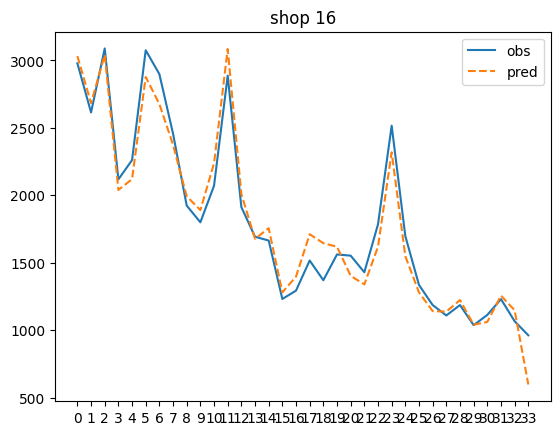

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/05xu0by_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ouq08oz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3150', 'data', 'file=/tmp/tmphfek2m2h/05xu0by_.json', 'init=/tmp/tmphfek2m2h/ouq08oz5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model2q0cnqwh/prophet_model-20241124192408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 17.000000--------------------------
-----------------------shop 18.000000--------------------------
predicted=1441.765211, expected=1211.000000
Test MSE: 230.765


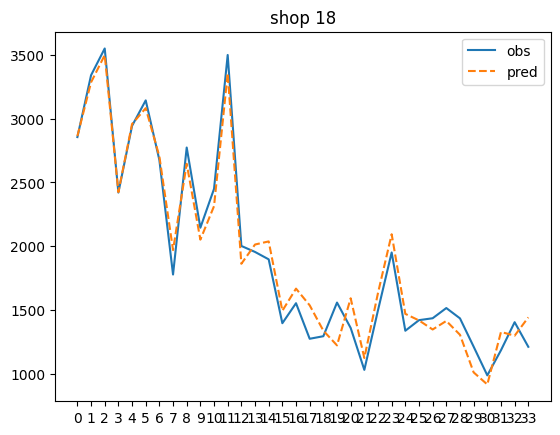

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4k7lz3me.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/8f8otzs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22896', 'data', 'file=/tmp/tmphfek2m2h/4k7lz3me.json', 'init=/tmp/tmphfek2m2h/8f8otzs5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model_f_ex8b9/prophet_model-20241124192409.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 19.000000--------------------------
predicted=2086.721305, expected=1449.000000
Test MSE: 637.721


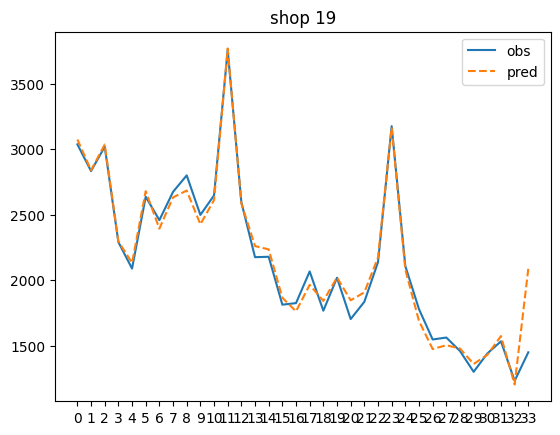

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/b3ofsx1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4zf09au2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94218', 'data', 'file=/tmp/tmphfek2m2h/b3ofsx1t.json', 'init=/tmp/tmphfek2m2h/4zf09au2.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelkrplp364/prophet_model-20241124192409.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 20.000000--------------------------
predicted=1485.576194, expected=2611.000000
Test MSE: 1125.424


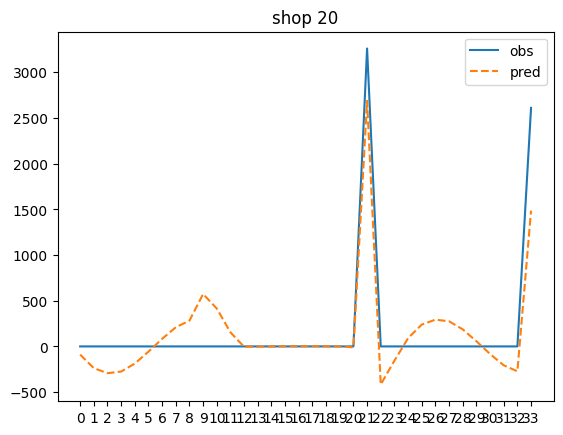

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/wh7gh9f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/k826r808.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16141', 'data', 'file=/tmp/tmphfek2m2h/wh7gh9f4.json', 'init=/tmp/tmphfek2m2h/k826r808.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model57zshzr2/prophet_model-20241124192410.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 21.000000--------------------------


19:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=2626.129085, expected=1912.000000
Test MSE: 714.129


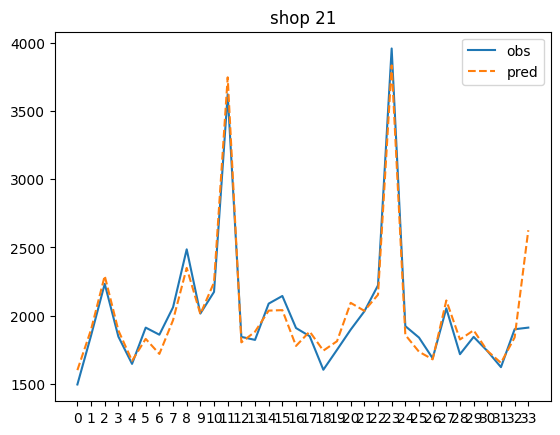

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/1zkjuwbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/iw7tv13a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49177', 'data', 'file=/tmp/tmphfek2m2h/1zkjuwbs.json', 'init=/tmp/tmphfek2m2h/iw7tv13a.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelf6apzren/prophet_model-20241124192410.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 22.000000--------------------------


19:24:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1780.758747, expected=1336.000000
Test MSE: 444.759


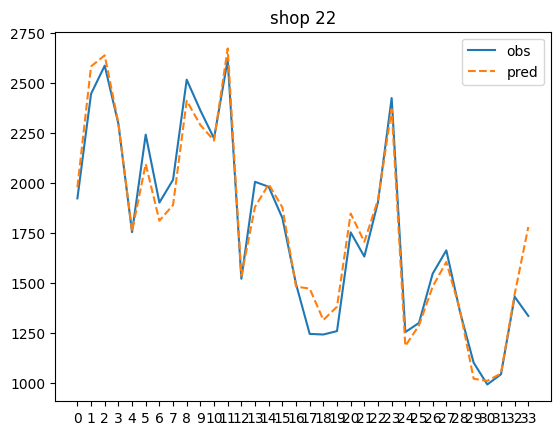

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/bhmajc09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/3tbyiyzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84110', 'data', 'file=/tmp/tmphfek2m2h/bhmajc09.json', 'init=/tmp/tmphfek2m2h/3tbyiyzu.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model_y5f8eoj/prophet_model-20241124192411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 23.000000--------------------------
-----------------------shop 24.000000--------------------------
predicted=1767.585318, expected=1227.000000
Test MSE: 540.585


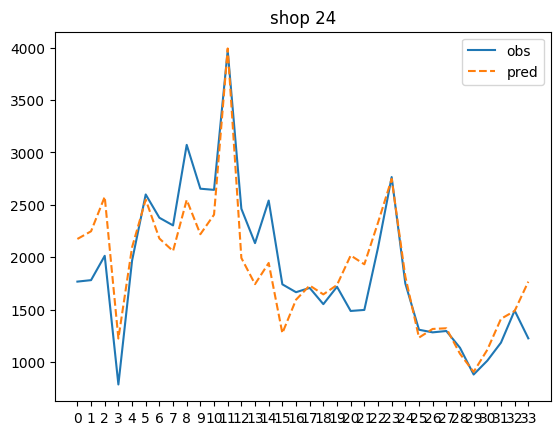

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4gdzczrm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/12luo1wz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79155', 'data', 'file=/tmp/tmphfek2m2h/4gdzczrm.json', 'init=/tmp/tmphfek2m2h/12luo1wz.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelvzv6oo3t/prophet_model-20241124192411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 25.000000--------------------------
predicted=6917.737481, expected=6247.000000
Test MSE: 670.737


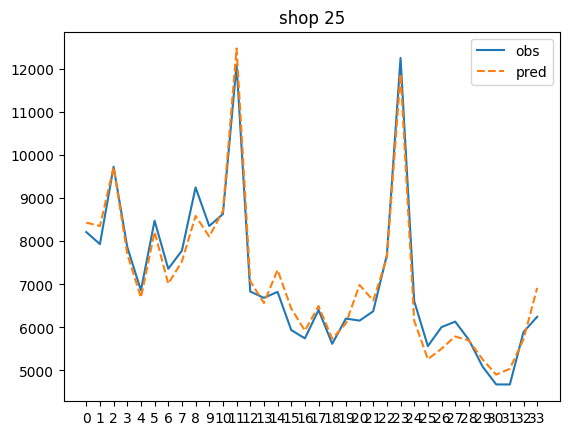

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/6kmky38l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/sotzrlwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12013', 'data', 'file=/tmp/tmphfek2m2h/6kmky38l.json', 'init=/tmp/tmphfek2m2h/sotzrlwe.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelbpiro2ym/prophet_model-20241124192412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 26.000000--------------------------
predicted=2251.160321, expected=1409.000000
Test MSE: 842.160


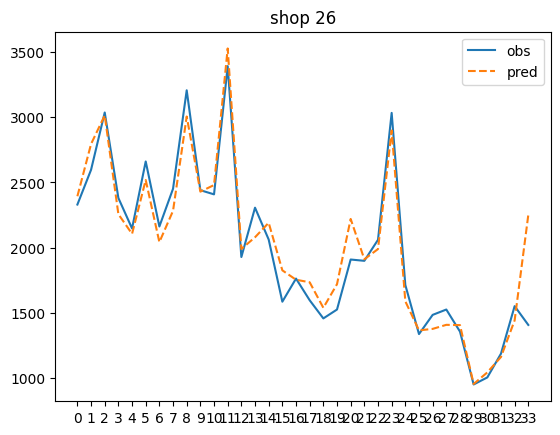

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dzy0qzdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/zlv8dimg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5783', 'data', 'file=/tmp/tmphfek2m2h/dzy0qzdz.json', 'init=/tmp/tmphfek2m2h/zlv8dimg.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelkzt2y_1r/prophet_model-20241124192412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 27.000000--------------------------
-----------------------shop 28.000000--------------------------
predicted=4694.068013, expected=3018.000000
Test MSE: 1676.068


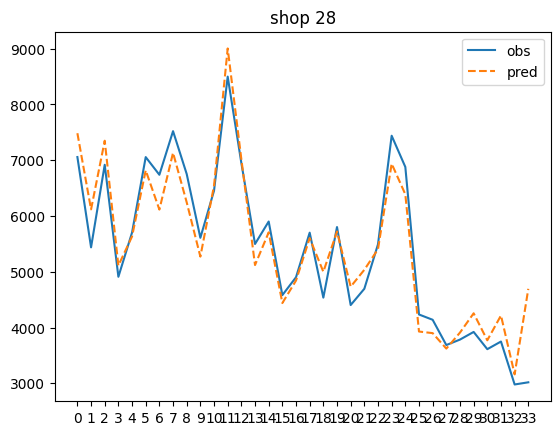

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/a62xl8bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/3ihpn852.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52765', 'data', 'file=/tmp/tmphfek2m2h/a62xl8bg.json', 'init=/tmp/tmphfek2m2h/3ihpn852.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelxgfz7ofk/prophet_model-20241124192413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 29.000000--------------------------
-----------------------shop 30.000000--------------------------
-----------------------shop 31.000000--------------------------
predicted=7993.206387, expected=6112.000000
Test MSE: 1881.206


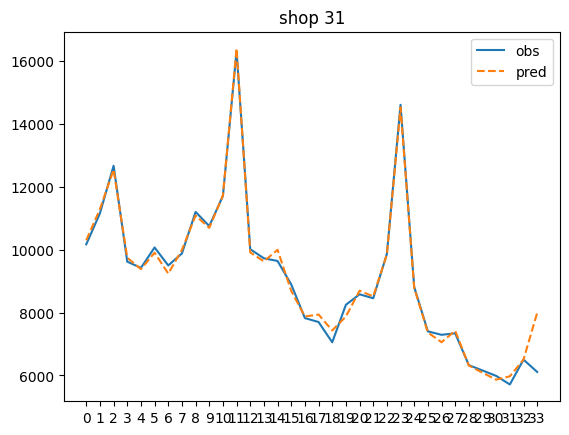

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/a9edarbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/nihqsus9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64978', 'data', 'file=/tmp/tmphfek2m2h/a9edarbs.json', 'init=/tmp/tmphfek2m2h/nihqsus9.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelny8za_re/prophet_model-20241124192413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 32.000000--------------------------
-----------------------shop 33.000000--------------------------
-----------------------shop 34.000000--------------------------
predicted=641.785846, expected=383.000000
Test MSE: 258.786


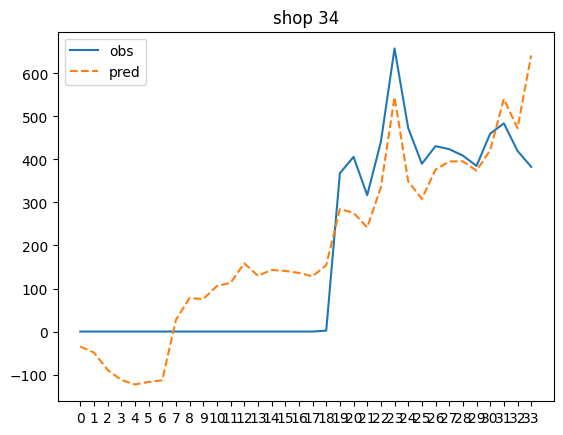

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/mrt9ostt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/27zaq6ex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81704', 'data', 'file=/tmp/tmphfek2m2h/mrt9ostt.json', 'init=/tmp/tmphfek2m2h/27zaq6ex.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelt5npijeg/prophet_model-20241124192414.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 35.000000--------------------------


19:24:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1791.979079, expected=1418.000000
Test MSE: 373.979


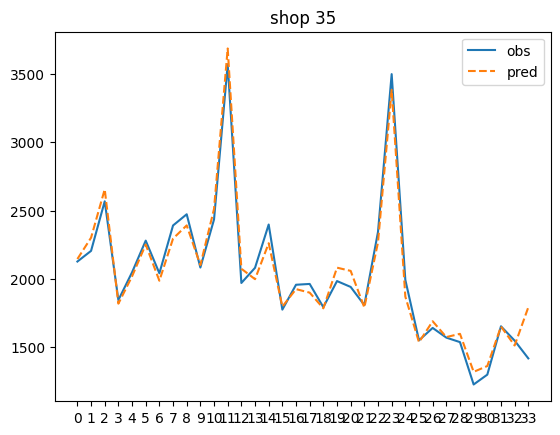

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/rsoaksl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/f99788iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11136', 'data', 'file=/tmp/tmphfek2m2h/rsoaksl0.json', 'init=/tmp/tmphfek2m2h/f99788iq.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model23rw5abg/prophet_model-20241124192414.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 36.000000--------------------------
-----------------------shop 37.000000--------------------------


19:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1675.275921, expected=833.000000
Test MSE: 842.276


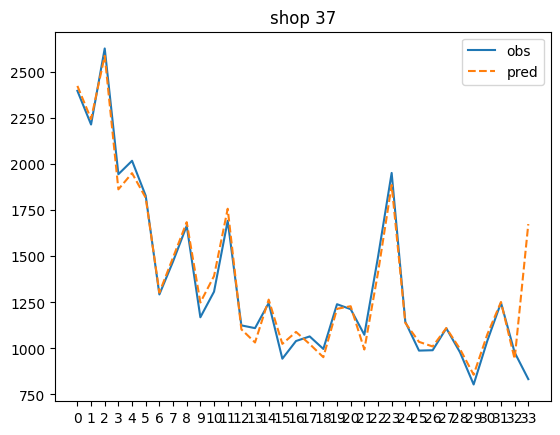

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dxt8fou2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/75pqq74r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14749', 'data', 'file=/tmp/tmphfek2m2h/dxt8fou2.json', 'init=/tmp/tmphfek2m2h/75pqq74r.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modely2kfswyx/prophet_model-20241124192415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:15 - cmdstanpy - INFO - Chain [1] done processing


-----------------------shop 38.000000--------------------------


INFO:cmdstanpy:Chain [1] done processing


predicted=1568.395351, expected=1110.000000
Test MSE: 458.395


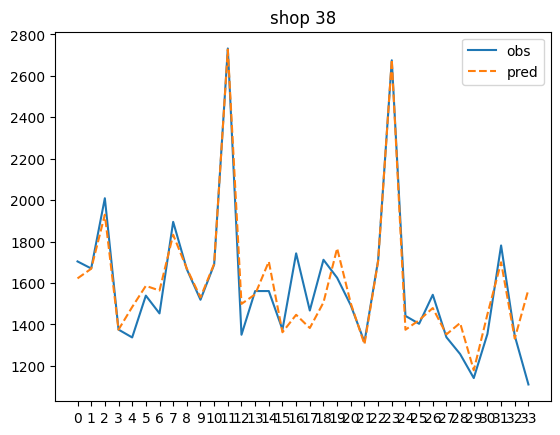

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/46b6or2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/xdq_yp4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59729', 'data', 'file=/tmp/tmphfek2m2h/46b6or2k.json', 'init=/tmp/tmphfek2m2h/xdq_yp4z.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelt3e586np/prophet_model-20241124192415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 39.000000--------------------------
predicted=1071.521443, expected=997.000000
Test MSE: 74.521


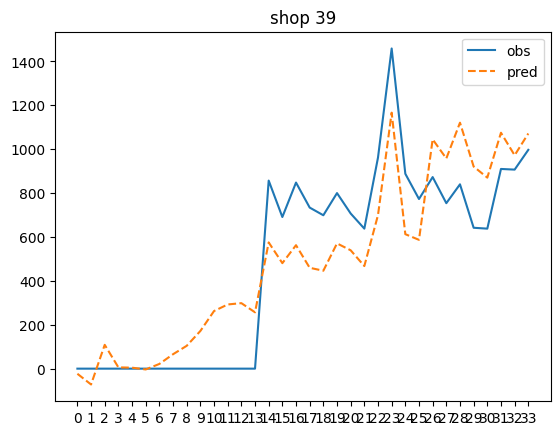

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/hgbfesgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/y2r9x5hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87499', 'data', 'file=/tmp/tmphfek2m2h/hgbfesgl.json', 'init=/tmp/tmphfek2m2h/y2r9x5hl.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modely3jgafsa/prophet_model-20241124192416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 40.000000--------------------------
-----------------------shop 41.000000--------------------------
predicted=656.699526, expected=742.000000
Test MSE: 85.300


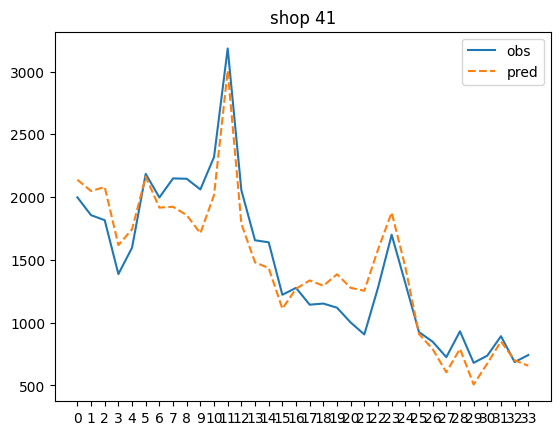

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/1sag_tmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/_q28l3g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17371', 'data', 'file=/tmp/tmphfek2m2h/1sag_tmj.json', 'init=/tmp/tmphfek2m2h/_q28l3g0.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model4mp84khy/prophet_model-20241124192416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 42.000000--------------------------
predicted=5385.942794, expected=4491.000000
Test MSE: 894.943


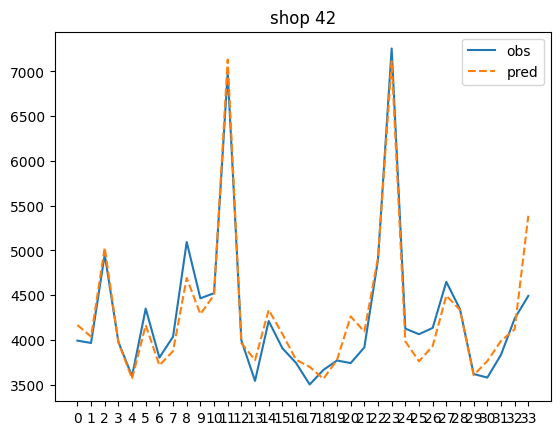

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ig9k7x8i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/188rwqmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43593', 'data', 'file=/tmp/tmphfek2m2h/ig9k7x8i.json', 'init=/tmp/tmphfek2m2h/188rwqmv.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model5zzluxmj/prophet_model-20241124192417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 43.000000--------------------------
-----------------------shop 44.000000--------------------------


19:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1244.838552, expected=779.000000
Test MSE: 465.839


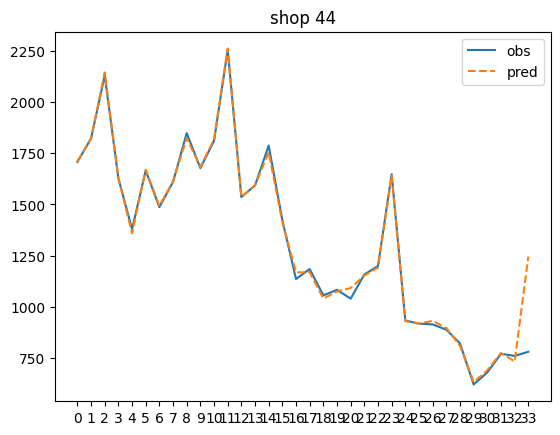

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/h_3qszqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/1jzx675x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65558', 'data', 'file=/tmp/tmphfek2m2h/h_3qszqn.json', 'init=/tmp/tmphfek2m2h/1jzx675x.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model3dnbhlyi/prophet_model-20241124192417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 45.000000--------------------------


19:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=784.011888, expected=702.000000
Test MSE: 82.012


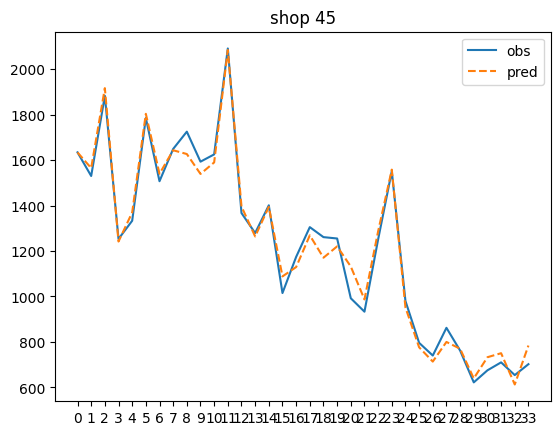

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/9v0oi9k0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/o0hz457r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16343', 'data', 'file=/tmp/tmphfek2m2h/9v0oi9k0.json', 'init=/tmp/tmphfek2m2h/o0hz457r.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelirrchqsu/prophet_model-20241124192418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 46.000000--------------------------


19:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1718.439449, expected=1320.000000
Test MSE: 398.439


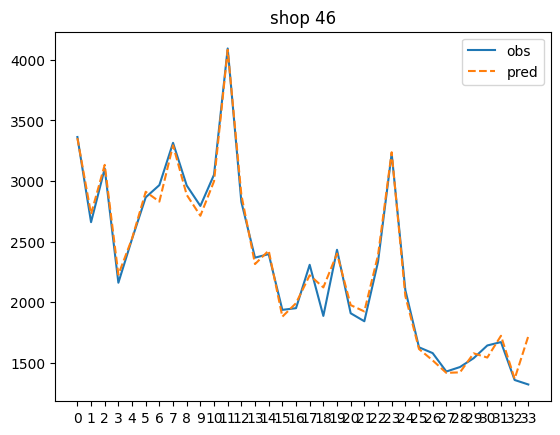

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/hxi0vnm1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/d9g1j6k_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77763', 'data', 'file=/tmp/tmphfek2m2h/hxi0vnm1.json', 'init=/tmp/tmphfek2m2h/d9g1j6k_.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model9_ec_1b0/prophet_model-20241124192418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 47.000000--------------------------


19:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=2010.639890, expected=1776.000000
Test MSE: 234.640


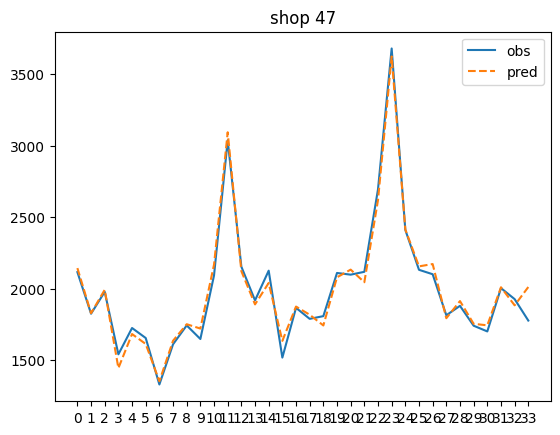

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/wisnb56q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/pxfodigz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10400', 'data', 'file=/tmp/tmphfek2m2h/wisnb56q.json', 'init=/tmp/tmphfek2m2h/pxfodigz.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelajs0cv9a/prophet_model-20241124192419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 48.000000--------------------------
predicted=2100.962491, expected=1111.000000
Test MSE: 989.962


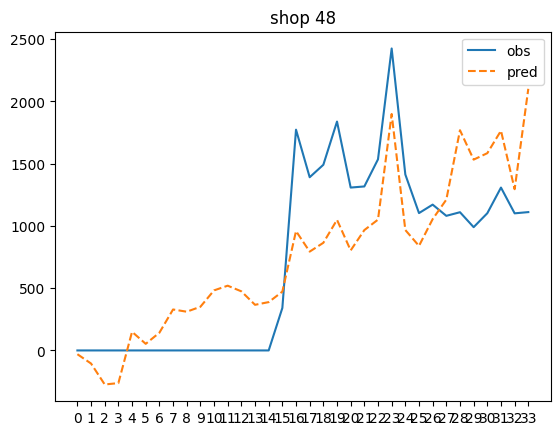

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/oadmm88z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/cozgk4fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47506', 'data', 'file=/tmp/tmphfek2m2h/oadmm88z.json', 'init=/tmp/tmphfek2m2h/cozgk4fw.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelznyv4187/prophet_model-20241124192419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 49.000000--------------------------


19:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1362.396704, expected=648.000000
Test MSE: 714.397


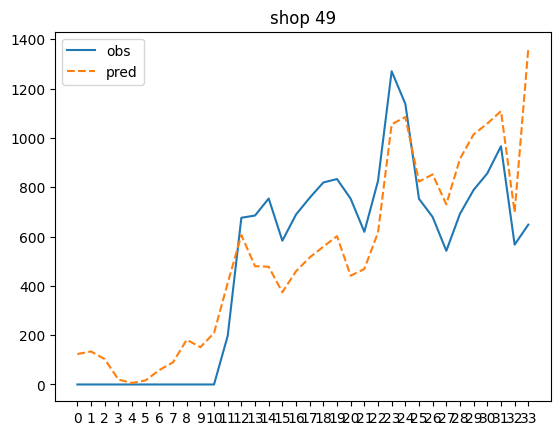

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/49spw517.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/bocz77gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77954', 'data', 'file=/tmp/tmphfek2m2h/49spw517.json', 'init=/tmp/tmphfek2m2h/bocz77gd.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelfgjc73mj/prophet_model-20241124192420.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 50.000000--------------------------
predicted=492.325294, expected=949.000000
Test MSE: 456.675


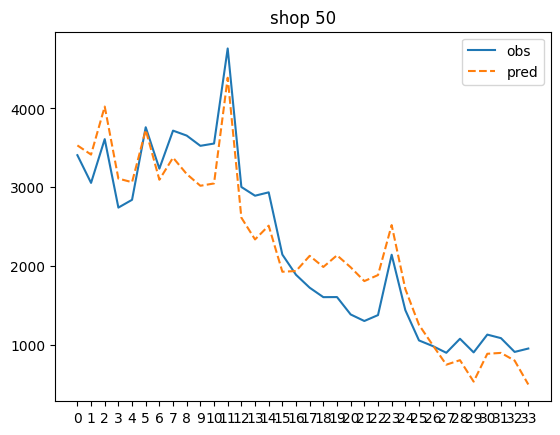

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/b2pfsk6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/90b_1sza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8491', 'data', 'file=/tmp/tmphfek2m2h/b2pfsk6j.json', 'init=/tmp/tmphfek2m2h/90b_1sza.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelc9mkafd4/prophet_model-20241124192420.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 51.000000--------------------------
-----------------------shop 52.000000--------------------------


19:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1231.234215, expected=847.000000
Test MSE: 384.234


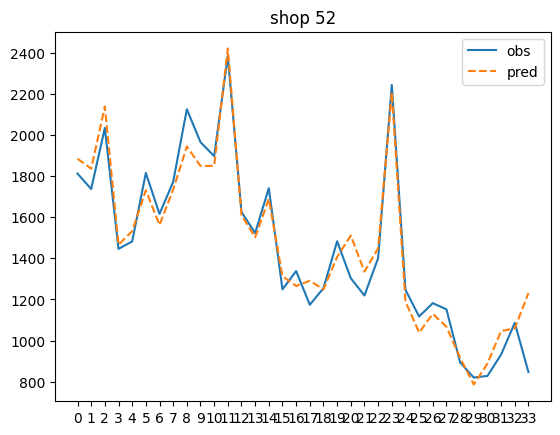

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/18ndaq66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/27tjlhuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25995', 'data', 'file=/tmp/tmphfek2m2h/18ndaq66.json', 'init=/tmp/tmphfek2m2h/27tjlhuj.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelet1iz2s5/prophet_model-20241124192421.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 53.000000--------------------------


19:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1550.388015, expected=1061.000000
Test MSE: 489.388


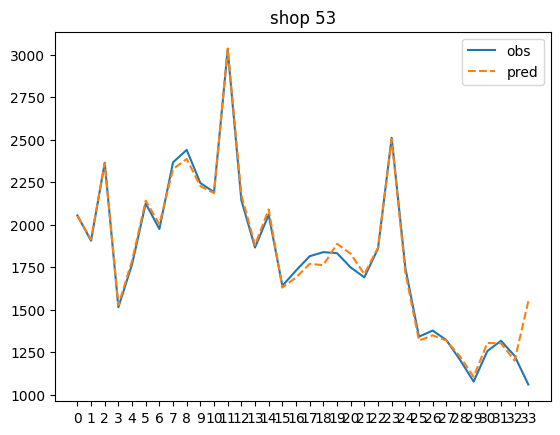

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/g0alg5_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/94lm15ol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11448', 'data', 'file=/tmp/tmphfek2m2h/g0alg5_g.json', 'init=/tmp/tmphfek2m2h/94lm15ol.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelndgh1x3a/prophet_model-20241124192422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 54.000000--------------------------
-----------------------shop 55.000000--------------------------


19:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=140.709959, expected=1972.000000
Test MSE: 1831.290


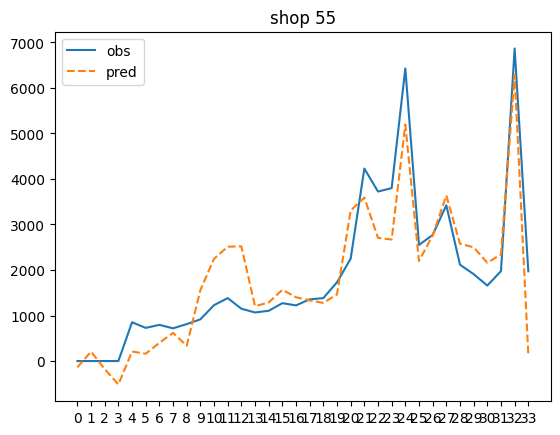

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/n14m6per.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/oqe4e4f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42326', 'data', 'file=/tmp/tmphfek2m2h/n14m6per.json', 'init=/tmp/tmphfek2m2h/oqe4e4f7.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelrfn0dwv7/prophet_model-20241124192422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


-----------------------shop 56.000000--------------------------
predicted=1419.463651, expected=1263.000000
Test MSE: 156.464


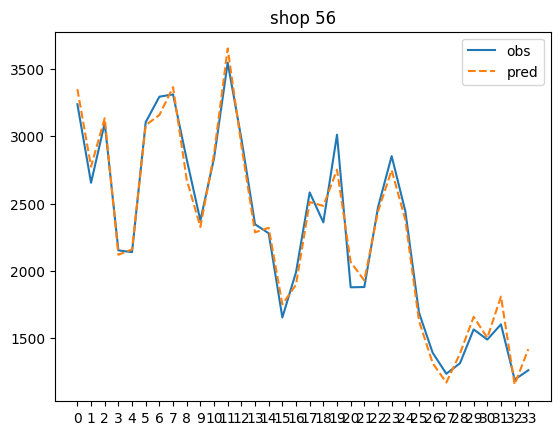

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/j3tzv4r1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dd9vlu9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63211', 'data', 'file=/tmp/tmphfek2m2h/j3tzv4r1.json', 'init=/tmp/tmphfek2m2h/dd9vlu9z.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelj9imx0z6/prophet_model-20241124192423.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 57.000000--------------------------


19:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1665.078533, expected=2316.000000
Test MSE: 650.921


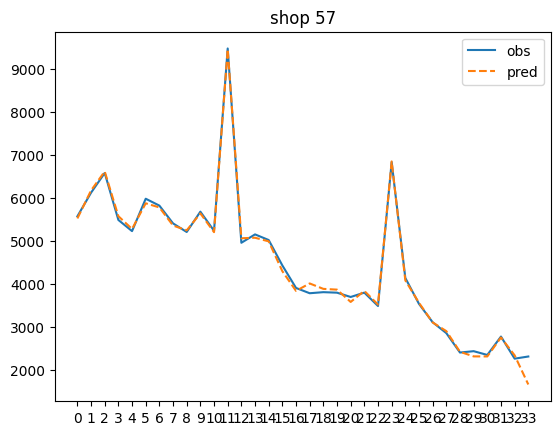

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/u3en41fj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/gy5gknjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40528', 'data', 'file=/tmp/tmphfek2m2h/u3en41fj.json', 'init=/tmp/tmphfek2m2h/gy5gknjv.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelqkkak3tm/prophet_model-20241124192423.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 58.000000--------------------------


19:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1503.921412, expected=1446.000000
Test MSE: 57.921


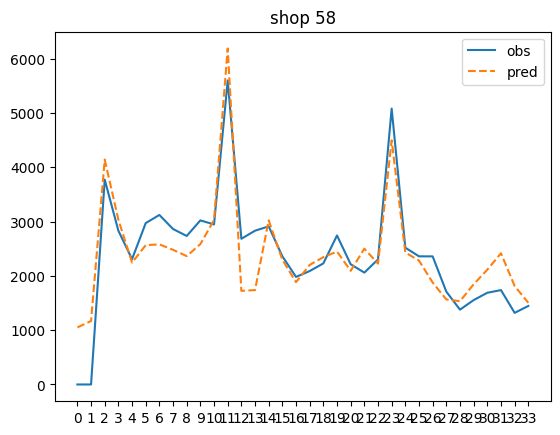

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4viyfmxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/_ca3qtd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49988', 'data', 'file=/tmp/tmphfek2m2h/4viyfmxy.json', 'init=/tmp/tmphfek2m2h/_ca3qtd_.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model0qncf_b9/prophet_model-20241124192424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


-----------------------shop 59.000000--------------------------


19:24:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


predicted=1588.942170, expected=790.000000
Test MSE: 798.942


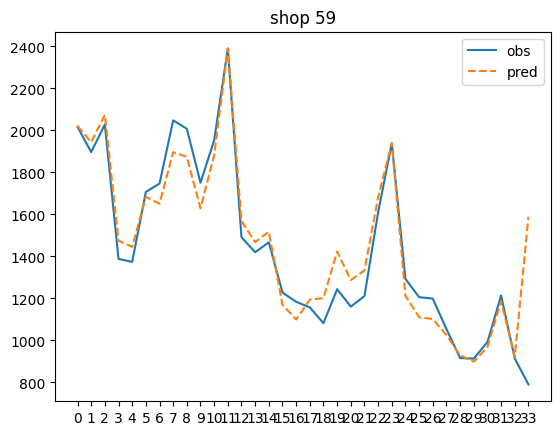

In [86]:
lista_pred_prophet=[]
for i in ts_prophet_shop.columns.tolist():
    lista_pred_prophet.append(train_evaluation_Prophet(ts_prophet_shop,i))

In [88]:
#df_pred_prophet=middleout_forecasting(lista_pred_prophet,3)
df_pred_prophet.rename(columns={'item_cnt_month':'pred'},inplace=True)

NameError: name 'df_pred_prophet' is not defined

Error evaluation:

In [89]:
error_prophet = evaluation(df_pred_prophet)
print('Test MSE: %.3f' % error_prophet)

NameError: name 'df_pred_prophet' is not defined

<a id = "prophet_prediction"></a>
### Prophet - Forecasting

In [90]:
def forecast_Prophet(ts,i):
    predictions = list()
    train=pd.DataFrame(ts[i]).reset_index()
    train.columns=['ds','y']

    if (i in closed_shops or sum(train['y'])==0):
        predictions.append(0)
    else:
        model = Prophet(yearly_seasonality=True)
        model.fit(train)
        future = model.make_future_dataframe(periods = 1, freq = 'MS',include_history=True)
        output = model.predict(future)['yhat']
        yhat = output.values[-1]
        predictions.append(yhat)

        plt.plot(train['y'],label='obs')
        plt.plot(output, label='pred',ls='--')
        plt.xticks(range(0,len(train)+1))
        plt.legend()
        plt.title('shop '+str(i))
        plt.show()

    predictions_series=pd.Series(predictions)
    return np.append(np.array(i),predictions_series.values.transpose())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dy6bowzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/lyv7wpit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93690', 'data', 'file=/tmp/tmphfek2m2h/dy6bowzu.json', 'init=/tmp/tmphfek2m2h/lyv7wpit.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelj50u81u8/prophet_model-20241124192505.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


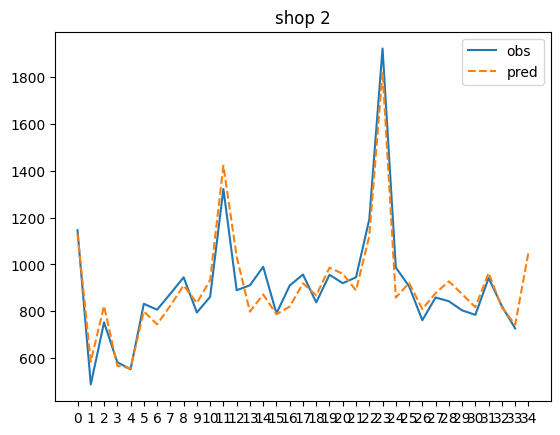

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/fjd_gjx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/va9_0cbl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72669', 'data', 'file=/tmp/tmphfek2m2h/fjd_gjx9.json', 'init=/tmp/tmphfek2m2h/va9_0cbl.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model_bh3cxy0/prophet_model-20241124192506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


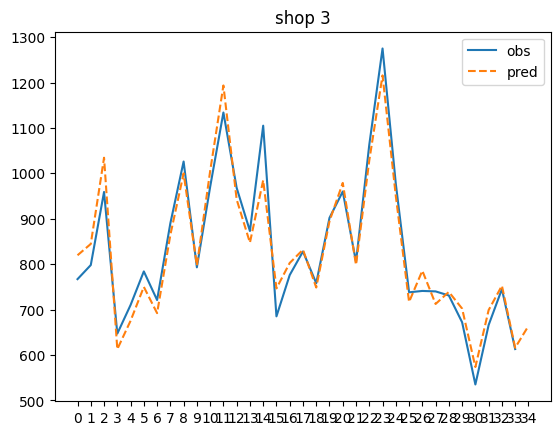

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/8a23mmq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/fwq7r2i5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44624', 'data', 'file=/tmp/tmphfek2m2h/8a23mmq7.json', 'init=/tmp/tmphfek2m2h/fwq7r2i5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelx4mfsygq/prophet_model-20241124192506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


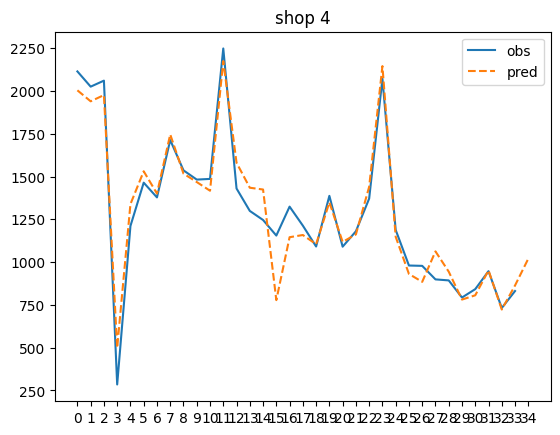

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/29x1cx_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/0c6z6zzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13225', 'data', 'file=/tmp/tmphfek2m2h/29x1cx_u.json', 'init=/tmp/tmphfek2m2h/0c6z6zzo.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model8og_qree/prophet_model-20241124192507.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


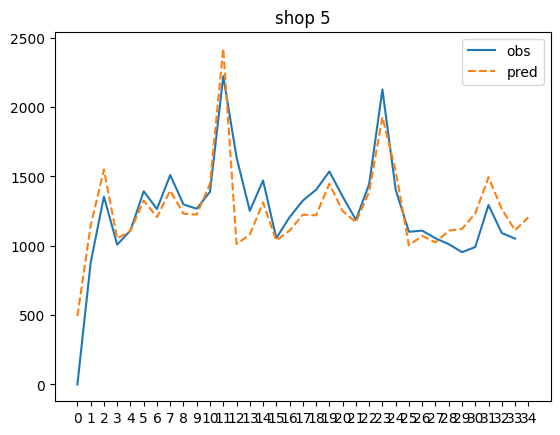

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/9ayvadv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/vrul1ab5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80092', 'data', 'file=/tmp/tmphfek2m2h/9ayvadv3.json', 'init=/tmp/tmphfek2m2h/vrul1ab5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelxilhdksm/prophet_model-20241124192508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


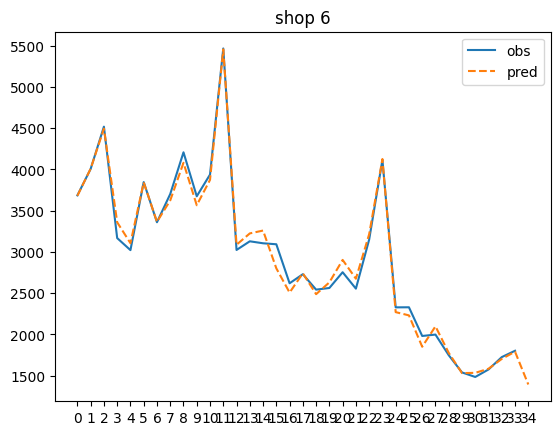

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/504xx7a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/7b_0ierk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74154', 'data', 'file=/tmp/tmphfek2m2h/504xx7a1.json', 'init=/tmp/tmphfek2m2h/7b_0ierk.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelb35k4u3s/prophet_model-20241124192508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


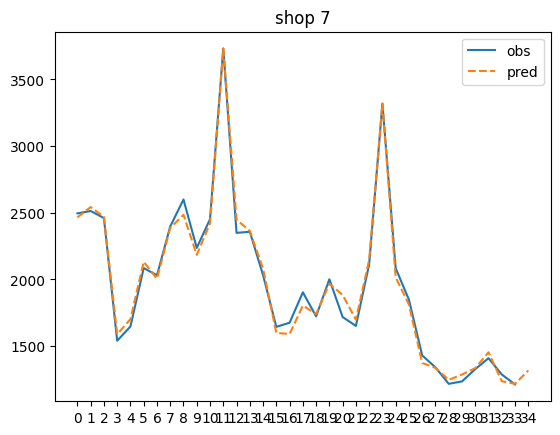

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/u45q39te.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/qtm1cmg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87224', 'data', 'file=/tmp/tmphfek2m2h/u45q39te.json', 'init=/tmp/tmphfek2m2h/qtm1cmg7.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelc9mqkv2v/prophet_model-20241124192509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


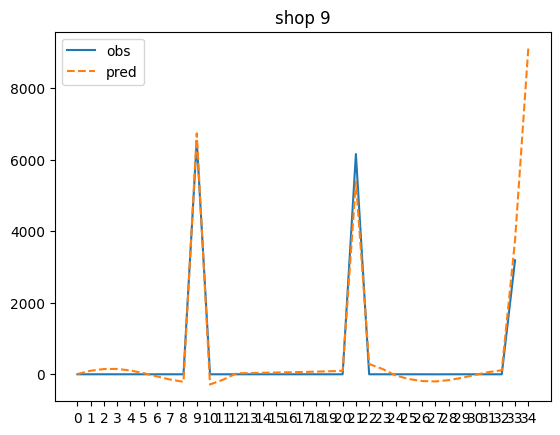

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/zqxwknro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/v97tr_k1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=707', 'data', 'file=/tmp/tmphfek2m2h/zqxwknro.json', 'init=/tmp/tmphfek2m2h/v97tr_k1.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model1eykjpwt/prophet_model-20241124192509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


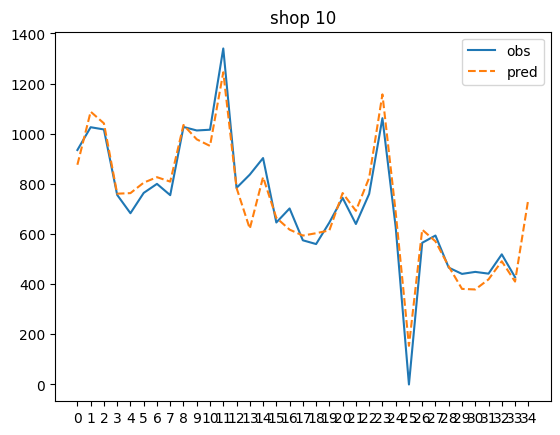

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/4hvg0cm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/5tfbr_ms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59896', 'data', 'file=/tmp/tmphfek2m2h/4hvg0cm3.json', 'init=/tmp/tmphfek2m2h/5tfbr_ms.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelc1_n92hk/prophet_model-20241124192510.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


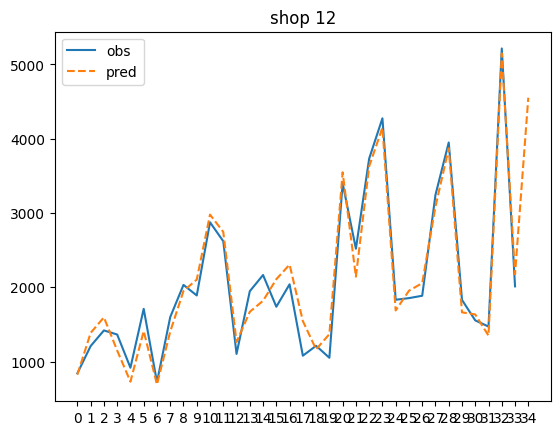

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/pocq9mcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/6c2jzwbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71230', 'data', 'file=/tmp/tmphfek2m2h/pocq9mcd.json', 'init=/tmp/tmphfek2m2h/6c2jzwbu.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelviwievk6/prophet_model-20241124192510.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


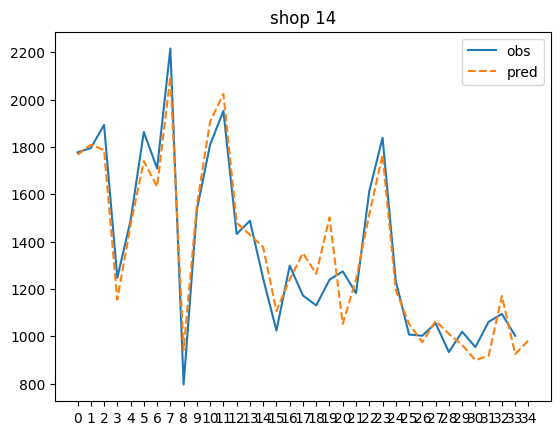

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/52z_sq8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dojbpelr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93618', 'data', 'file=/tmp/tmphfek2m2h/52z_sq8f.json', 'init=/tmp/tmphfek2m2h/dojbpelr.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modeldgp09hpw/prophet_model-20241124192511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


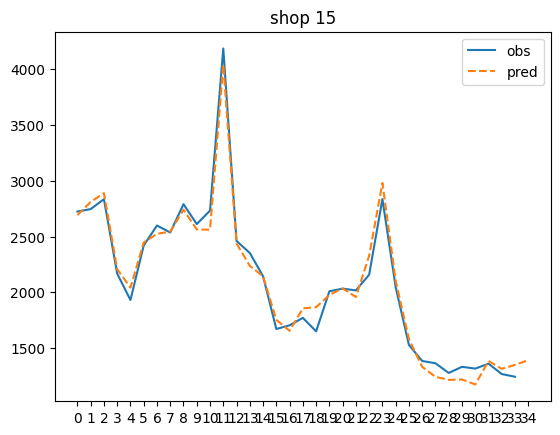

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/mtpk4xmm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/5wjx49qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2143', 'data', 'file=/tmp/tmphfek2m2h/mtpk4xmm.json', 'init=/tmp/tmphfek2m2h/5wjx49qm.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model261buejv/prophet_model-20241124192511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


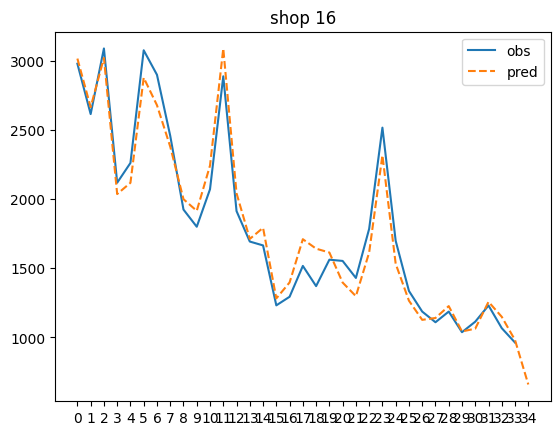

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/nzqbhccb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/euz0ge12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88836', 'data', 'file=/tmp/tmphfek2m2h/nzqbhccb.json', 'init=/tmp/tmphfek2m2h/euz0ge12.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model7l76sn3c/prophet_model-20241124192511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


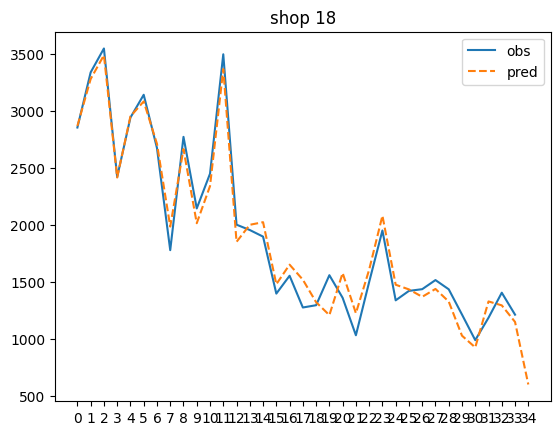

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/z2fbth3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/8eh49ke2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55624', 'data', 'file=/tmp/tmphfek2m2h/z2fbth3d.json', 'init=/tmp/tmphfek2m2h/8eh49ke2.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelgvtb4ay5/prophet_model-20241124192512.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


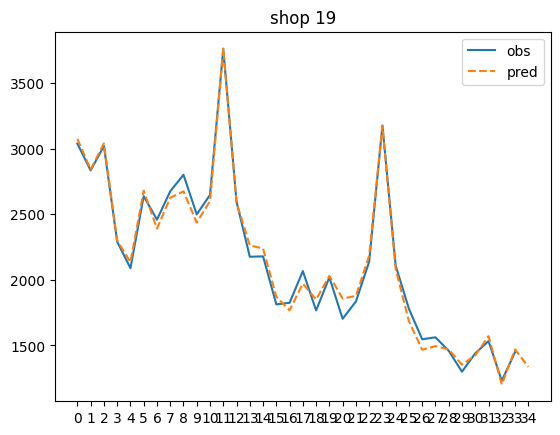

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/3am79hz7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ut9ey0d5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97477', 'data', 'file=/tmp/tmphfek2m2h/3am79hz7.json', 'init=/tmp/tmphfek2m2h/ut9ey0d5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelujaj27mm/prophet_model-20241124192512.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


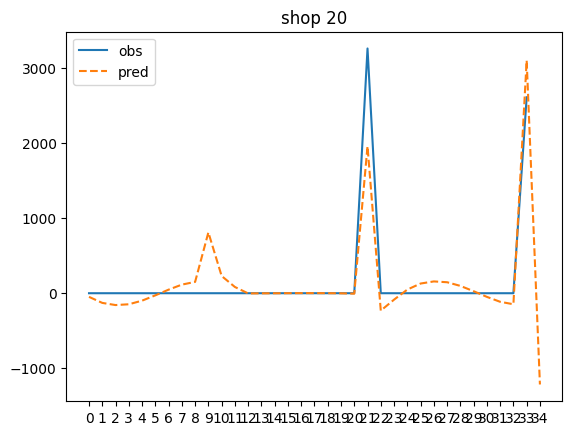

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/j8r2160z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/jndrrjma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51241', 'data', 'file=/tmp/tmphfek2m2h/j8r2160z.json', 'init=/tmp/tmphfek2m2h/jndrrjma.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelmzh93kih/prophet_model-20241124192513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


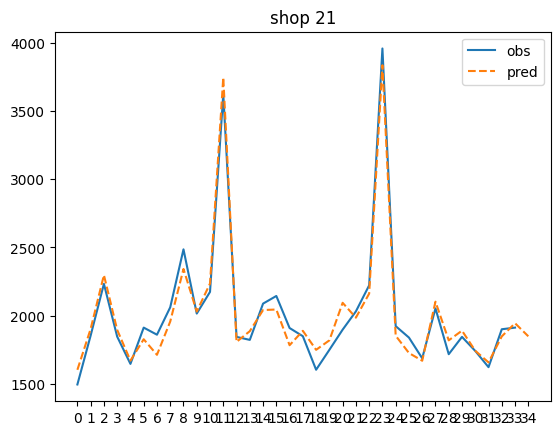

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/p3wq1iku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/f09bhmjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44736', 'data', 'file=/tmp/tmphfek2m2h/p3wq1iku.json', 'init=/tmp/tmphfek2m2h/f09bhmjz.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelgd1m9wvs/prophet_model-20241124192514.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


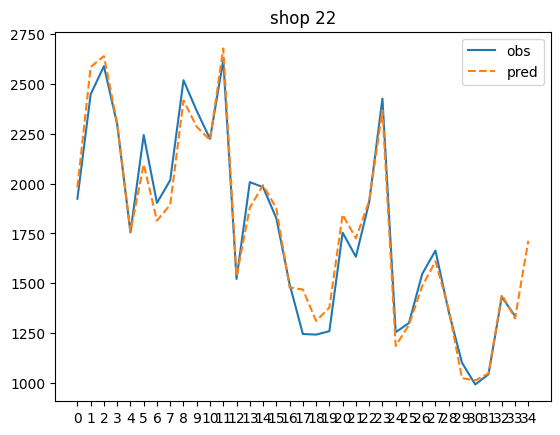

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/2srbsg0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/k5evq3u1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68460', 'data', 'file=/tmp/tmphfek2m2h/2srbsg0n.json', 'init=/tmp/tmphfek2m2h/k5evq3u1.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model1bmx8vir/prophet_model-20241124192514.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


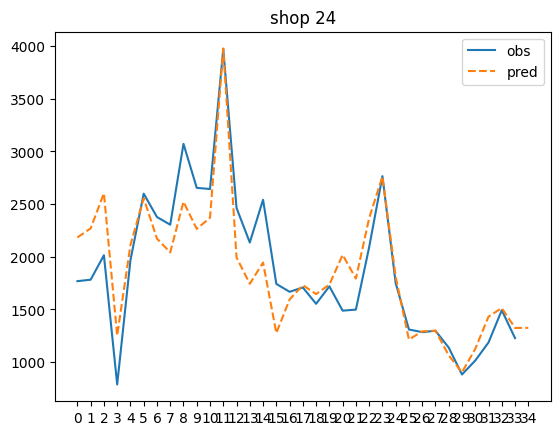

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/hneqk6mo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/y0_44xnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19367', 'data', 'file=/tmp/tmphfek2m2h/hneqk6mo.json', 'init=/tmp/tmphfek2m2h/y0_44xnh.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model62qwux3c/prophet_model-20241124192515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


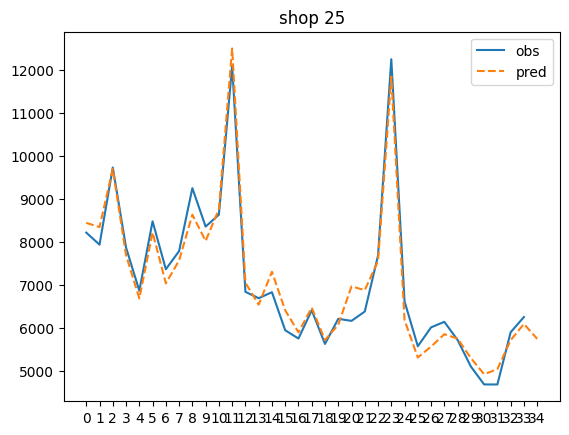

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/pa9yeh87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/f85tx9ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23488', 'data', 'file=/tmp/tmphfek2m2h/pa9yeh87.json', 'init=/tmp/tmphfek2m2h/f85tx9ja.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelt6jn602e/prophet_model-20241124192515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


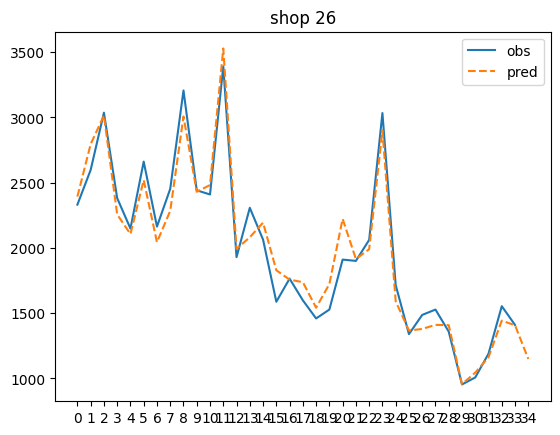

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/racj72ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/i7msa1vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86162', 'data', 'file=/tmp/tmphfek2m2h/racj72ba.json', 'init=/tmp/tmphfek2m2h/i7msa1vb.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modele7tjxnh7/prophet_model-20241124192515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


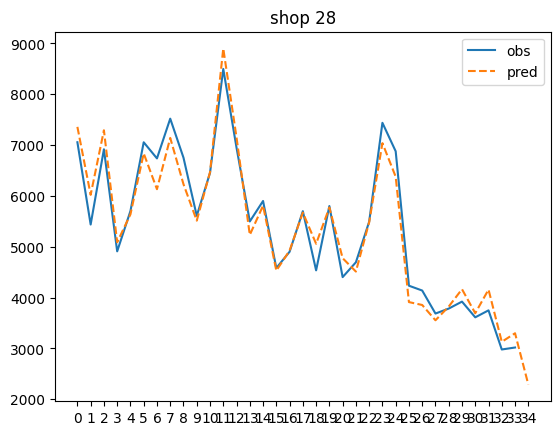

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/jg25lzjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dktsqqzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57127', 'data', 'file=/tmp/tmphfek2m2h/jg25lzjy.json', 'init=/tmp/tmphfek2m2h/dktsqqzk.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelqyrisp4f/prophet_model-20241124192516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


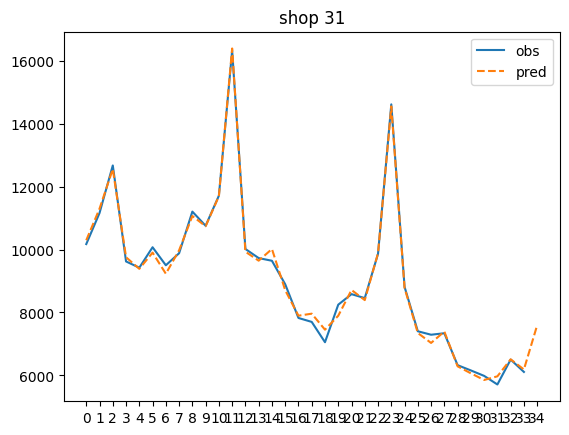

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/0sy7pxhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/klr4zhct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98758', 'data', 'file=/tmp/tmphfek2m2h/0sy7pxhk.json', 'init=/tmp/tmphfek2m2h/klr4zhct.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelg396ojey/prophet_model-20241124192517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


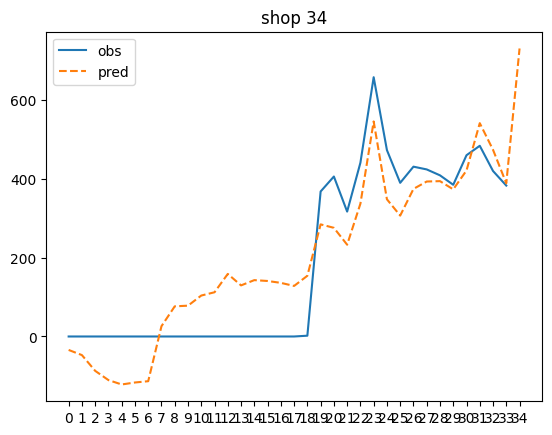

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/7ga5u0wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/mlq6iqz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57125', 'data', 'file=/tmp/tmphfek2m2h/7ga5u0wh.json', 'init=/tmp/tmphfek2m2h/mlq6iqz1.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model92tgf370/prophet_model-20241124192517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


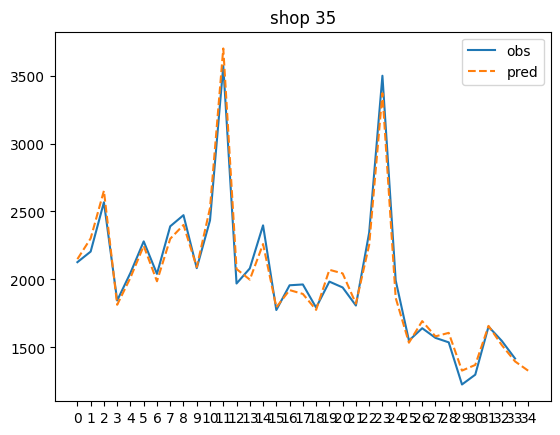

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/qoj0hza5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/r96c70ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2589', 'data', 'file=/tmp/tmphfek2m2h/qoj0hza5.json', 'init=/tmp/tmphfek2m2h/r96c70ib.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model5hztfaft/prophet_model-20241124192518.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


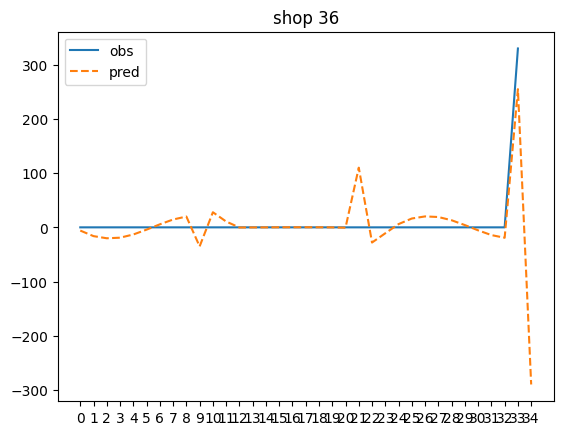

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/n2f4eg1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/75mwwnew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37643', 'data', 'file=/tmp/tmphfek2m2h/n2f4eg1r.json', 'init=/tmp/tmphfek2m2h/75mwwnew.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modeltg9ovac4/prophet_model-20241124192518.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


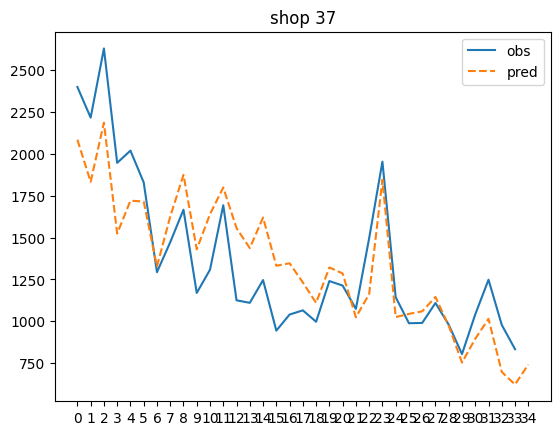

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/f8abet6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/04d7k6am.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59666', 'data', 'file=/tmp/tmphfek2m2h/f8abet6v.json', 'init=/tmp/tmphfek2m2h/04d7k6am.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modeld7p2p3fj/prophet_model-20241124192518.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


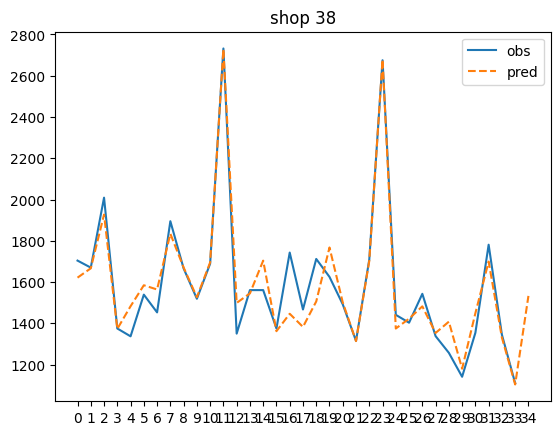

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/a38v44l0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dcj9ov5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89239', 'data', 'file=/tmp/tmphfek2m2h/a38v44l0.json', 'init=/tmp/tmphfek2m2h/dcj9ov5h.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelre4tp8je/prophet_model-20241124192519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


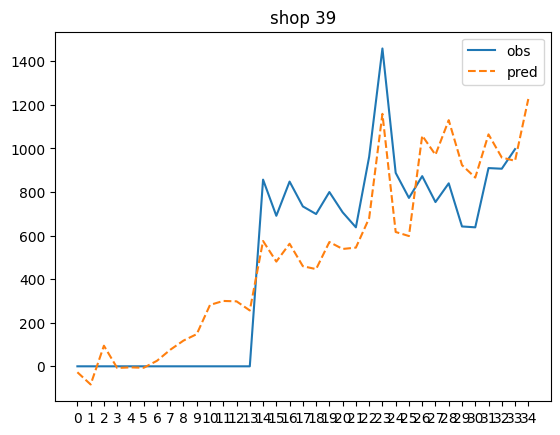

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/aq6ovq4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/3zu7t80k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75050', 'data', 'file=/tmp/tmphfek2m2h/aq6ovq4i.json', 'init=/tmp/tmphfek2m2h/3zu7t80k.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelr5bf5eki/prophet_model-20241124192519.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


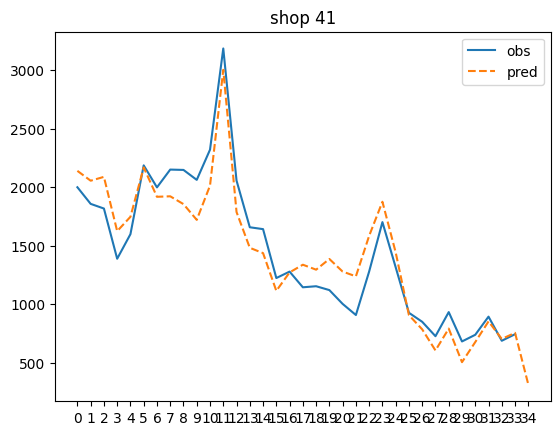

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/6co_so3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ark33_mx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68657', 'data', 'file=/tmp/tmphfek2m2h/6co_so3t.json', 'init=/tmp/tmphfek2m2h/ark33_mx.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model5whdhsuh/prophet_model-20241124192520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


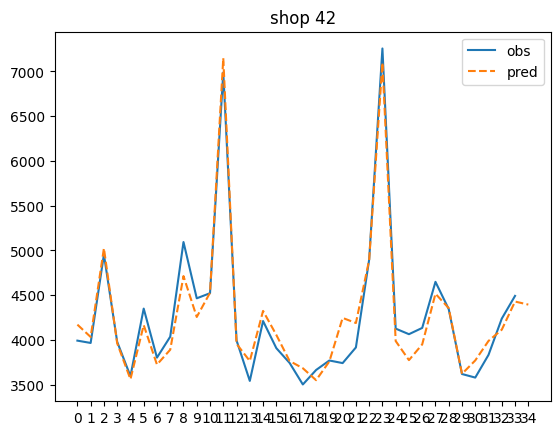

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/bzd1nxjw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/733xvcq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43470', 'data', 'file=/tmp/tmphfek2m2h/bzd1nxjw.json', 'init=/tmp/tmphfek2m2h/733xvcq5.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelwk6ep68k/prophet_model-20241124192521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


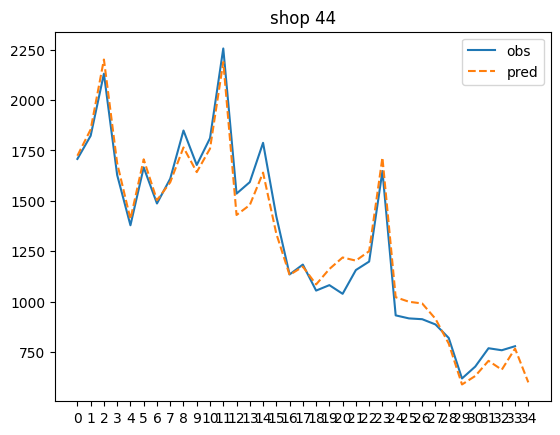

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/mheptngu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/booaoda0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12745', 'data', 'file=/tmp/tmphfek2m2h/mheptngu.json', 'init=/tmp/tmphfek2m2h/booaoda0.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelglc4ddvs/prophet_model-20241124192521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


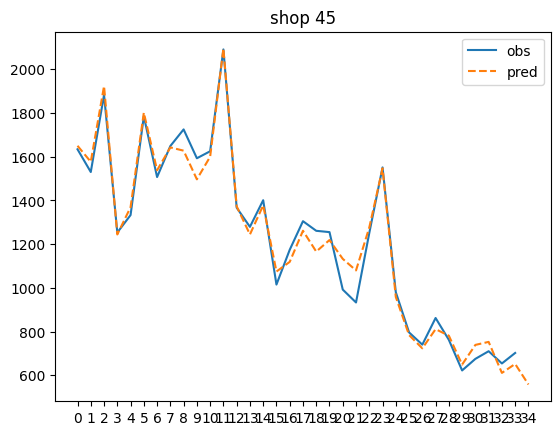

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/kdefhfke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/5m7cqv0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60853', 'data', 'file=/tmp/tmphfek2m2h/kdefhfke.json', 'init=/tmp/tmphfek2m2h/5m7cqv0z.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model0wusglrs/prophet_model-20241124192522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


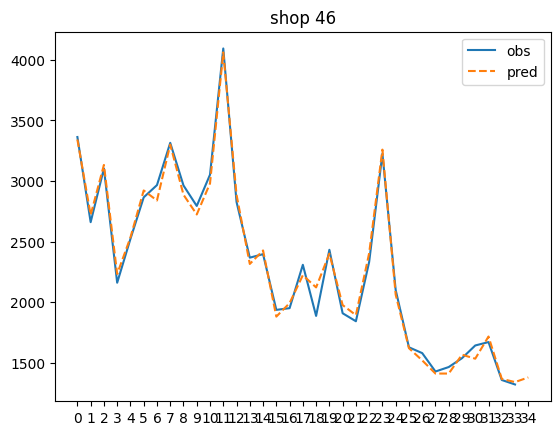

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/rj62wiqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/kcazyghj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13897', 'data', 'file=/tmp/tmphfek2m2h/rj62wiqd.json', 'init=/tmp/tmphfek2m2h/kcazyghj.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_models9e5jojs/prophet_model-20241124192522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


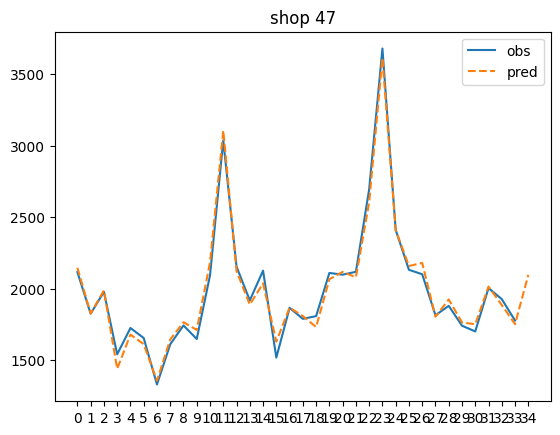

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/yhsaagc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/xu3qfelt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78263', 'data', 'file=/tmp/tmphfek2m2h/yhsaagc5.json', 'init=/tmp/tmphfek2m2h/xu3qfelt.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model8tyoh1vp/prophet_model-20241124192523.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


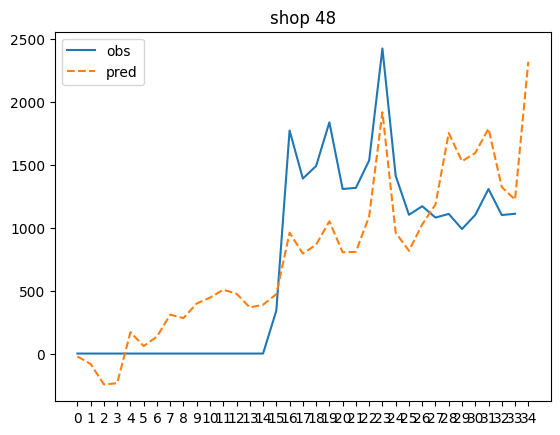

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/3ofd84nb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/zsr_vanu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35472', 'data', 'file=/tmp/tmphfek2m2h/3ofd84nb.json', 'init=/tmp/tmphfek2m2h/zsr_vanu.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model781k5ud0/prophet_model-20241124192523.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


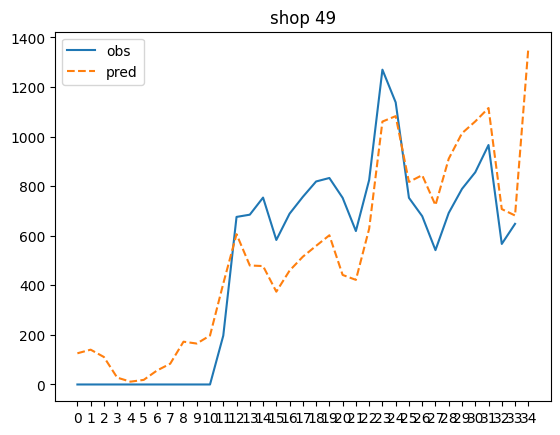

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/z0yq94oj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/dzg0hejj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70672', 'data', 'file=/tmp/tmphfek2m2h/z0yq94oj.json', 'init=/tmp/tmphfek2m2h/dzg0hejj.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelemp1pdp0/prophet_model-20241124192523.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


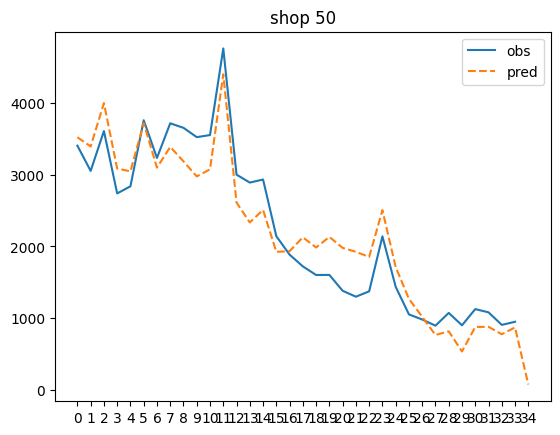

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/qed9wzec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/m5iklqeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48404', 'data', 'file=/tmp/tmphfek2m2h/qed9wzec.json', 'init=/tmp/tmphfek2m2h/m5iklqeu.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modellv41_dg6/prophet_model-20241124192524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


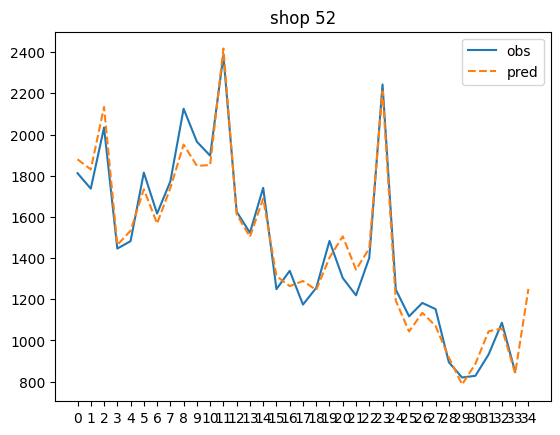

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/iq3w1xbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/jqcawmmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58237', 'data', 'file=/tmp/tmphfek2m2h/iq3w1xbp.json', 'init=/tmp/tmphfek2m2h/jqcawmmo.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modeln12ag_h6/prophet_model-20241124192524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


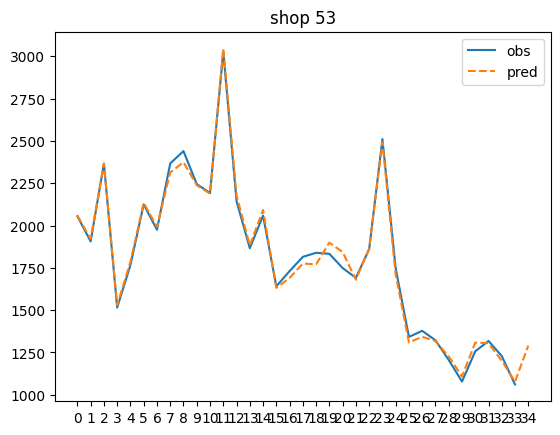

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/9p_48tpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/2jlj09jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13684', 'data', 'file=/tmp/tmphfek2m2h/9p_48tpb.json', 'init=/tmp/tmphfek2m2h/2jlj09jp.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelu_4u5y_p/prophet_model-20241124192525.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


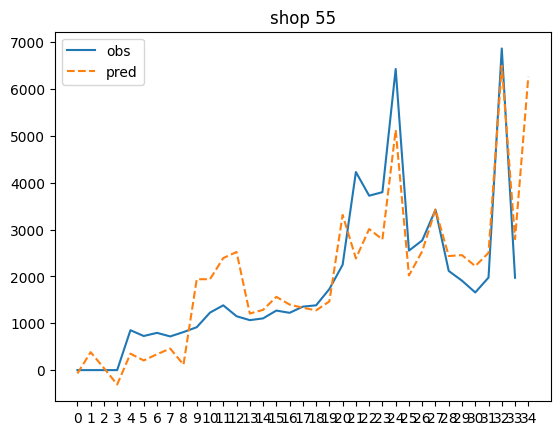

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/nij5l1w2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/10wgbalm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96652', 'data', 'file=/tmp/tmphfek2m2h/nij5l1w2.json', 'init=/tmp/tmphfek2m2h/10wgbalm.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelats04_fq/prophet_model-20241124192525.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


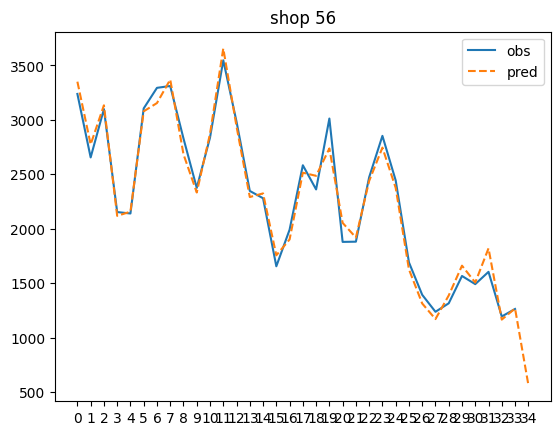

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/m0zcj20v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/m8t5i_68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1670', 'data', 'file=/tmp/tmphfek2m2h/m0zcj20v.json', 'init=/tmp/tmphfek2m2h/m8t5i_68.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelgfx1x3ip/prophet_model-20241124192526.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


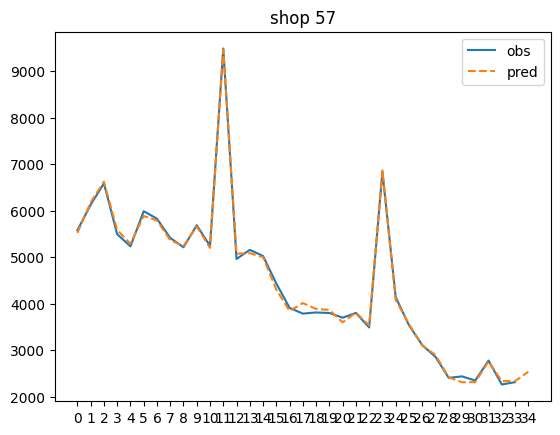

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/m2smjs0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ty0zzve8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20334', 'data', 'file=/tmp/tmphfek2m2h/m2smjs0z.json', 'init=/tmp/tmphfek2m2h/ty0zzve8.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_model9tbv8cg3/prophet_model-20241124192527.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


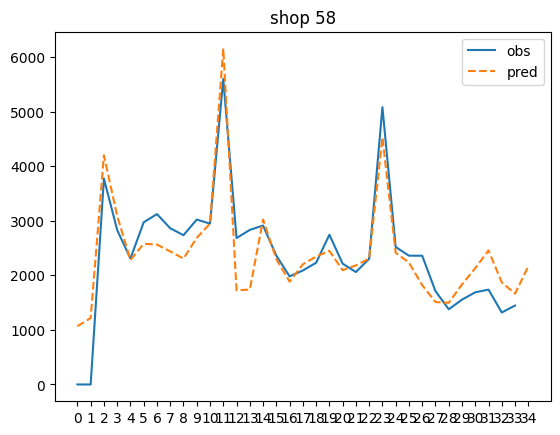

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/vm1o42v3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfek2m2h/ciu45nch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62784', 'data', 'file=/tmp/tmphfek2m2h/vm1o42v3.json', 'init=/tmp/tmphfek2m2h/ciu45nch.json', 'output', 'file=/tmp/tmphfek2m2h/prophet_modelzh31kh_a/prophet_model-20241124192527.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


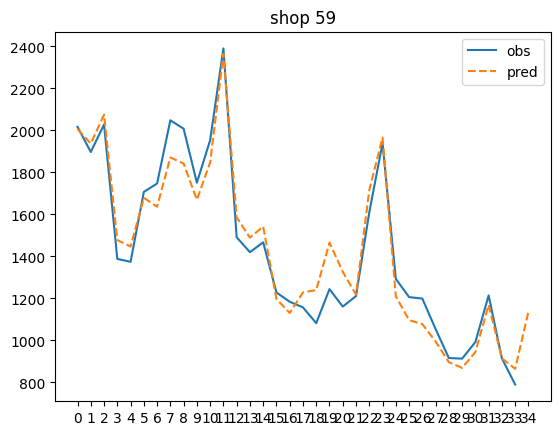

In [91]:
lista_pred_test_prophet=[]
for i in ts_prophet_shop.columns.tolist():
    lista_pred_test_prophet.append(forecast_Prophet(ts_prophet_shop,i))

In [92]:
df_forecast_prophet=middleout_forecasting(lista_pred_test_prophet,3)

KeyError: 'shop_id'

With enough computing power we wouldn't need to use the TOP-DOWN method and we would be able to forecast at the lowest hierarchical level. If that were the case, it would be a very good idea to explore XGB with more lag features at the item level. Exploring SARIMAX with yearly seasonality would also be an interesting approach. Prophet is a very easy to use and quick way to do a forecast, it's a great option for a quick solution.